## Test Batch Normalization on tissues


**Question:** How does combat batch normalization algorithms perform on adjacent section tissues stained with the same panel, when training with unmatched cores?

**Samples:** 
- TMA: Purchased from biomax: https://www.biomax.us/tissue-arrays/Breast/BR1506
- Adjacent Sections: BM-Her2N75-15, BM-Her2N75-17, BM-Her2N75-18 (section 16 skipped.)
- Scenes: (i.e. TMA cores) 
  - 17: ER+/HER2+, immune rich. 
  - 49: ER+/HER2+
  - 59: HER2+ immune rich

**Method**: We performed combat normalization using unlike tissues as training set (different cores in training set and all cores in testing set). We visualized the resulting histograms.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import scipy
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, minmax_scale, StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import visualize as viz, process, preprocess, normalize
np.random.seed(1202)
np.random.seed(1211)

In [2]:
#change to correct directory
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir=os.getcwd()
rootdir = f'{codedir}/Data/'
datadir = f'{codedir}/Data/filtered_data'
os.chdir(datadir)
%matplotlib inline

In [58]:
# load data
df=pd.read_csv(f'20201229_BM-Her2N75-15-17-18_MeanIntensity.csv',index_col=0)
df.rename({'slide':'batch'},axis=1,inplace=True)

In [63]:
df.groupby('slide_scene').mean().loc[:,['CK7_Ring','CK14_Ring','CK5_Ring','CK19_Ring','Ecad_Ring','HER2_Ring']]

CK7_Ring    CK14_Ring     CK5_Ring    CK19_Ring  \
slide_scene                                                                  
BM-Her2N75-15_scene017   924.257881   539.136801   636.898739  1235.706517   
BM-Her2N75-15_scene049  2315.451275   523.766524   727.284430  2381.923358   
BM-Her2N75-15_scene059  2472.093054  1040.766751  1191.882537  3201.597365   
BM-Her2N75-17_scene017  1658.296062   289.161667   380.095287  1561.775633   
BM-Her2N75-17_scene049  2873.132608   320.095182   433.295056  2615.069371   
BM-Her2N75-17_scene059  3650.401482   493.269476   629.190463  3581.402932   
BM-Her2N75-18_scene017  1492.836562   648.318157   784.074305  1391.912762   
BM-Her2N75-18_scene049  3327.062905   660.366325   890.003454  2370.588385   
BM-Her2N75-18_scene059  5503.145527  1261.903737  1331.717592  3059.274661   

                          Ecad_Ring    HER2_Ring  
slide_scene                                       
BM-Her2N75-15_scene017  2539.270065  2349.921664  
BM-Her2N75-15_scene049  2352.344368  2217.666990  
BM-Her2N75-15_scene059  3115.667558  2732.367516  
BM-Her2N75-17_scene017  2256.643874  2601.826464  
BM-Her2N75-17_scene049  2055.494900  2339.631725  
BM-Her2N75-17_scene059  2711.039454  2625.967270  
BM-Her2N75-18_scene017  1542.587185  2009.261293  
BM-Her2N75-18_scene049  2002.715098  1843.874169  
BM-Her2N75-18_scene059  2322.556610  2190.586101

In [4]:
def plot_histograms(df_norm,df,s_train,s_tissue):
    df_norm['batch'] = [item.split('_')[0] for item in df_norm.index]
    bins=50
    for s_marker in df_norm.columns[df_norm.dtypes=='float64']:
        print(s_marker)
        fig,ax=plt.subplots(2,1,figsize = (5,5))
        for idxs, s_batch in enumerate(sorted(set(df_norm.batch))):
            df_batch = df_norm[(df_norm.batch==s_batch)].loc[:,s_marker] 
            if len(df_batch.dropna()) == 0:
                continue
            ax[0].hist(df.loc[df.index.str.contains(s_batch),s_marker],bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[1].hist(df_batch,bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[0].set_yscale('log')
            ax[1].set_yscale('log')
            ax[0].set_title(f'{s_marker.split("_")[0]}: Raw Data {s_train}')
            ax[1].set_title(f'{s_marker.split("_")[0]}: Combat')
            ax[0].legend()
        plt.tight_layout()
        fig.savefig(f'{rootdir}/20201228/Different_Scaling_combat_training_{s_train}_{s_marker}_{s_tissue}.png')


In [ ]:
#all cores
data = df.loc[:,df.dtypes=='float64'].T
batch = df.batch
gamma_star, delta_star = normalize.combat_fit(data, batch)
#transform
bayesdata = normalize.combat_transform(data,batch,gamma_star, delta_star)
df_norm=bayesdata.T
s_train='all'
s_tissue = 'all'
plot_histograms(df_norm,df,s_train,s_tissue)

## Training combat with controls

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat?
- Can a limited set of tissues be used to fit combat?
- Or, should the set of tissues used to fit combat be very similar to those it is applied to?

In [5]:
lls_batch = [['BM-Her2N75-15', 'BM-Her2N75-17', 'BM-Her2N75-18'],
            [ 'BM-Her2N75-17', 'BM-Her2N75-18','BM-Her2N75-15'],
            [ 'BM-Her2N75-18','BM-Her2N75-15', 'BM-Her2N75-17']]
ls_scene = sorted(set(df.scene))

In [ ]:
#normalize with different training sets
for idxx, ls_batch in enumerate(lls_batch):
    data = pd.DataFrame()
    for idx, s_batch in enumerate(ls_batch):
        s_scene = ['scene017', 'scene049', 'scene059'][idx]
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star, stand_mean, var_pooled = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star,stand_mean, var_pooled)
    df_norm=bayesdata.T
    s_train = "_".join([(item + ls_scene[idx]).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'diff'
    plot_histograms(df_norm,data,s_train,s_tissue)
    break
    df_norm.sample(5400,random_state=3).to_csv(f'20210301-{idxx}_BM-Her2N75_SampledMeanIntensity_diff_train.csv')


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


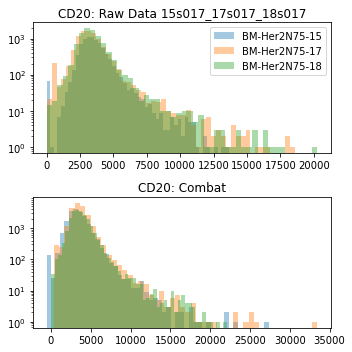

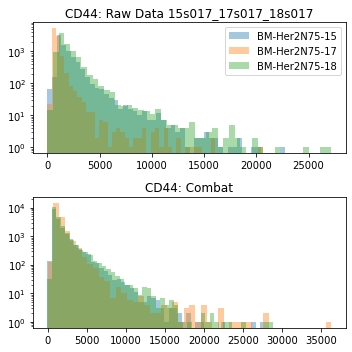

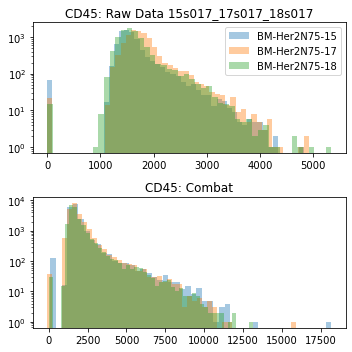

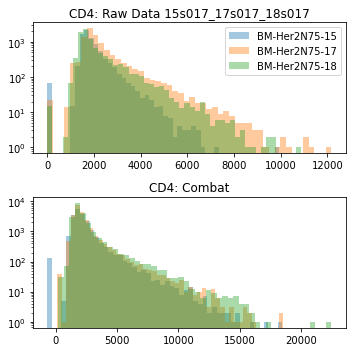

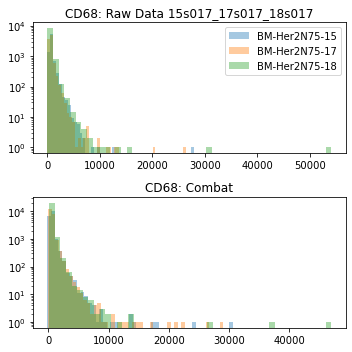

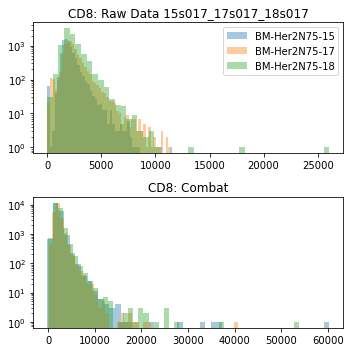

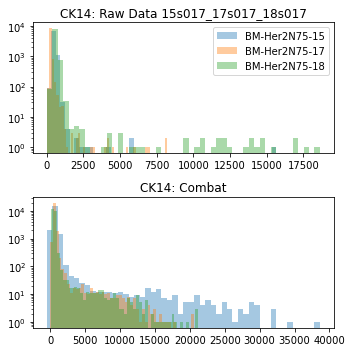

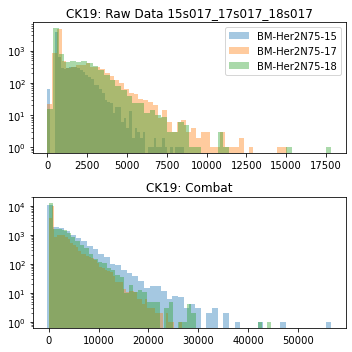

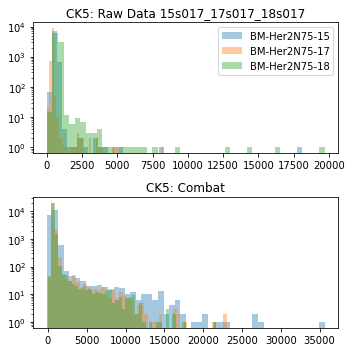

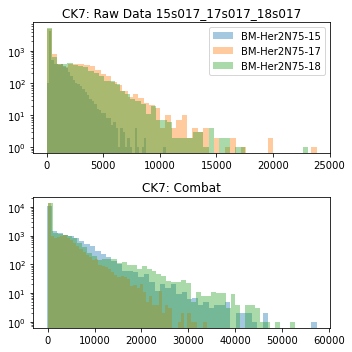

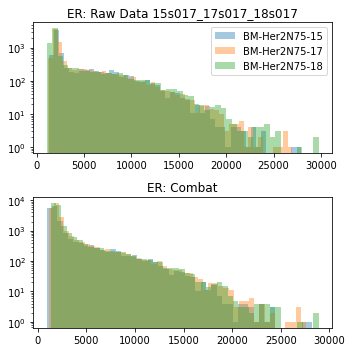

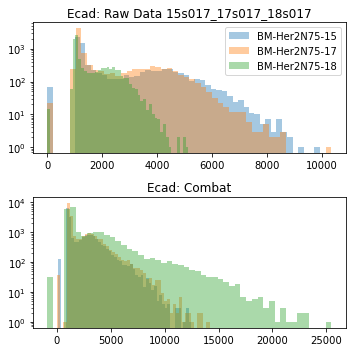

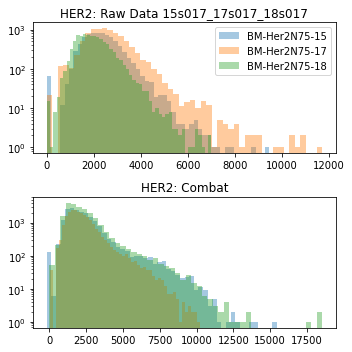

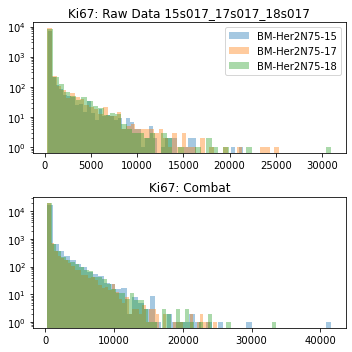

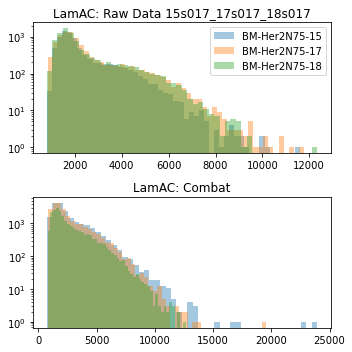

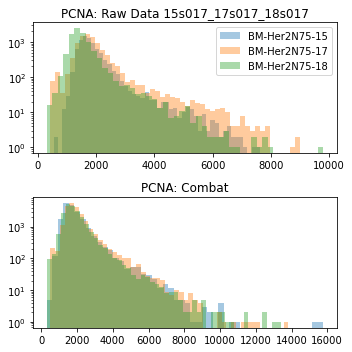

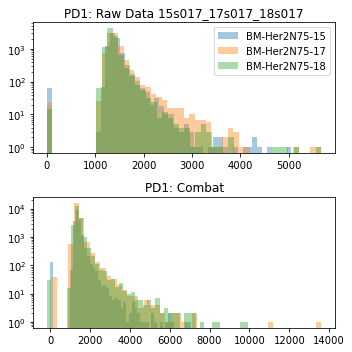

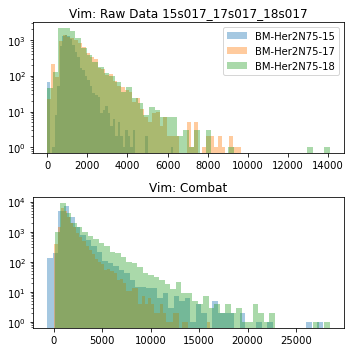

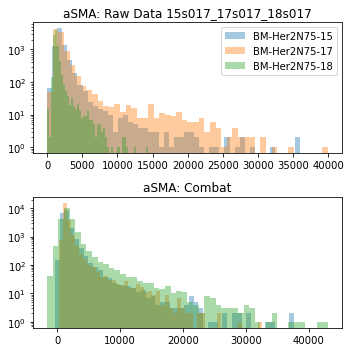

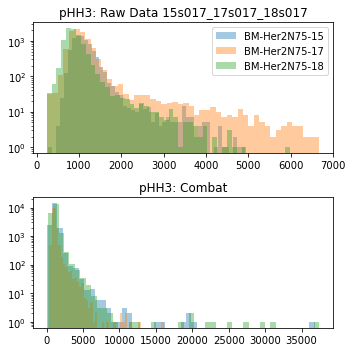

In [53]:
#normalize with same training sets
for idx, ls_batch in enumerate(lls_batch):
    s_scene = ['scene017', 'scene049', 'scene059'][idx]
    data = pd.DataFrame()
    for s_batch in ls_batch:   
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star, stand_mean, var_pooled = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star, stand_mean, var_pooled)
    df_norm=bayesdata.T
    s_train = "_".join([(item + s_scene).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'same'
    plot_histograms(df_norm,data,s_train,s_tissue)
    break
    df_norm.sample(5400,random_state=3).to_csv(f'20210301-{idx}_BM-Her2N75_SampledMeanIntensity_same_train.csv')


note: 
20210301-0_BM-Her2N75-15-17-18_kbet_same_train.csv gave the worst kbet results
this is the ER+/HER2+, immune rich core
markers failed on were CK14,  CK5, CK7, and Ecad; HER2 and CK19 to a lesser degree.

found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


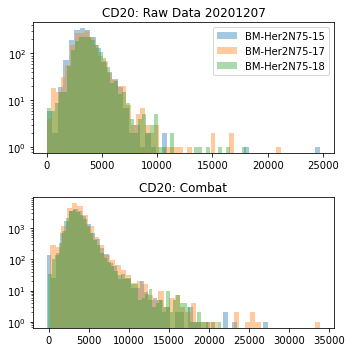

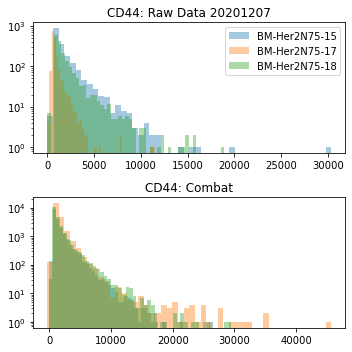

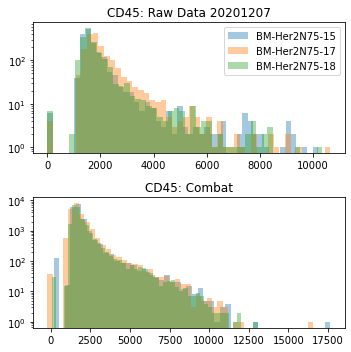

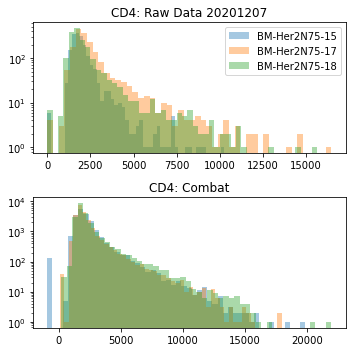

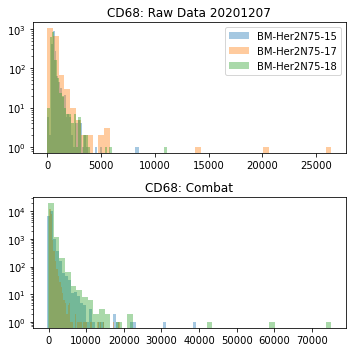

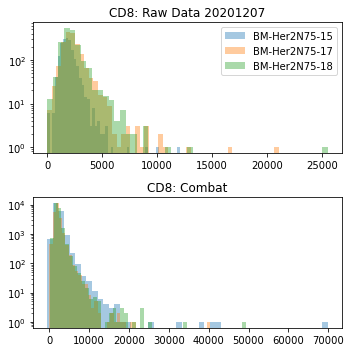

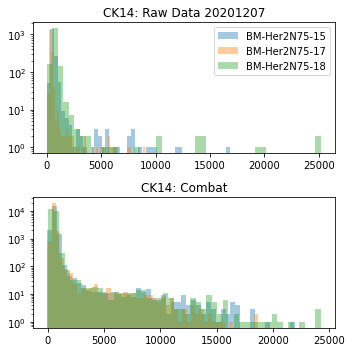

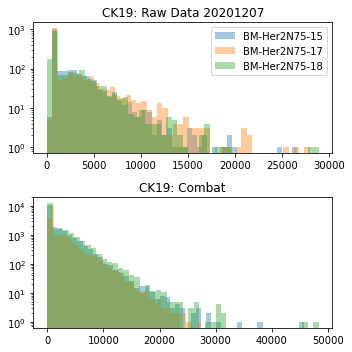

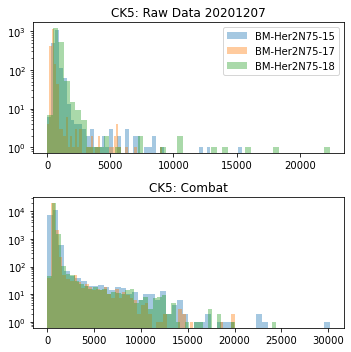

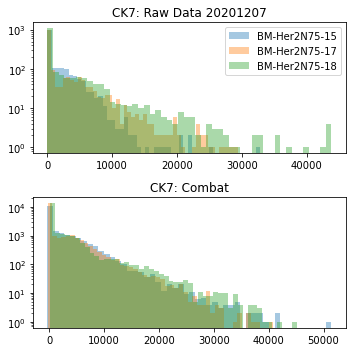

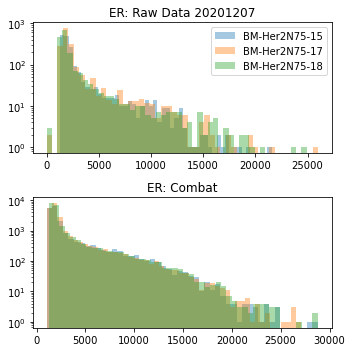

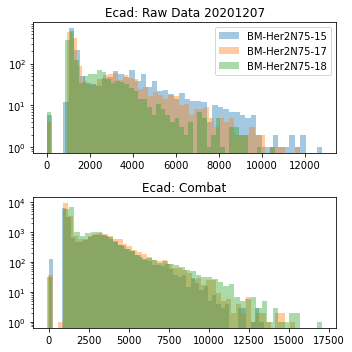

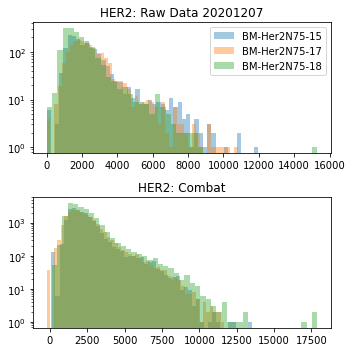

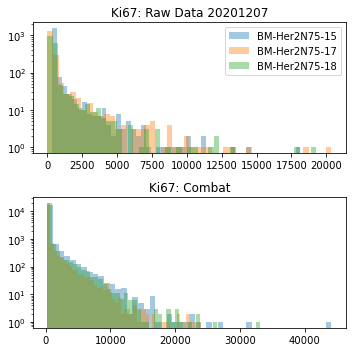

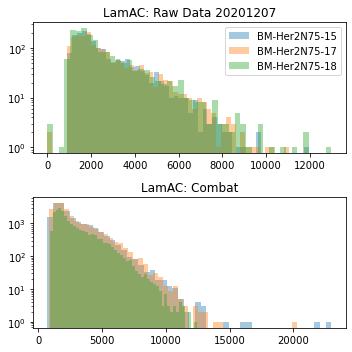

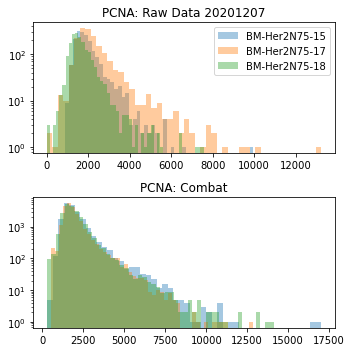

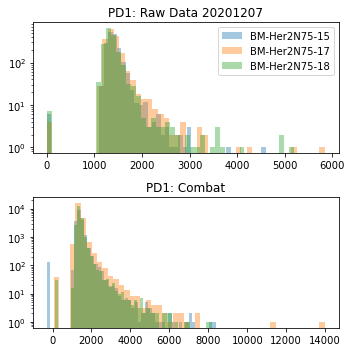

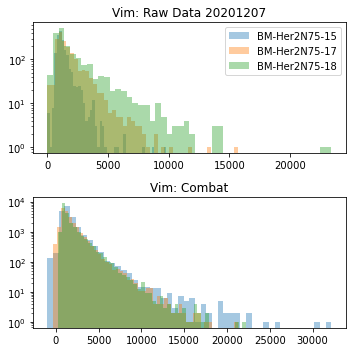

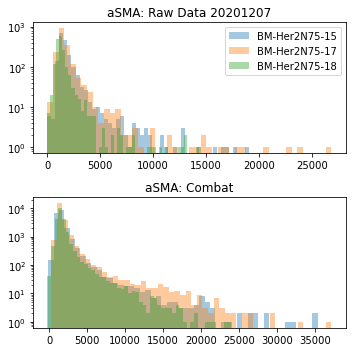

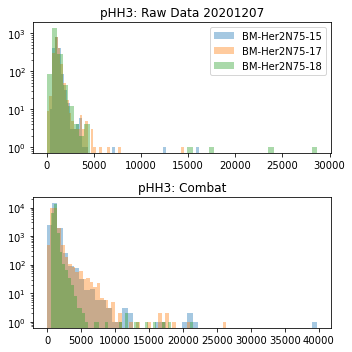

In [55]:
#normalize with sampled training sets
ls_date = ['20201207','20201208','20201209']
for idx, s_date in enumerate(ls_date):
    data = pd.read_csv(f'{s_date}_BM-Her2N75-15-17-18_SampledMeanIntensity_raw.csv',index_col=0)
    data['batch'] = [item.split('_')[0] for item in data.index]
    #fit training set
    gamma_star, delta_star, stand_mean, var_pooled = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star, stand_mean, var_pooled)
    df_norm=bayesdata.T
    s_train = s_date
    s_tissue = 'sampled'
    plot_histograms(df_norm,data,s_train,s_tissue)
    break
    df_norm.sample(5400,random_state=3).to_csv(f'20210301-{idx}_BM-Her2N75_SampledMeanIntensity_sampled_train.csv')


## RESTORE methods: Results

What is the best practice for restore normalization?

- Global or local thresholds? - **Local slightly better but neither very good**
- Raw data or arcsinh transformation? - **No difference**
- Divide by threshold or scale values above threshold? - **Scale gives good normaliztion, but not as good as combat**

In [16]:
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet')]

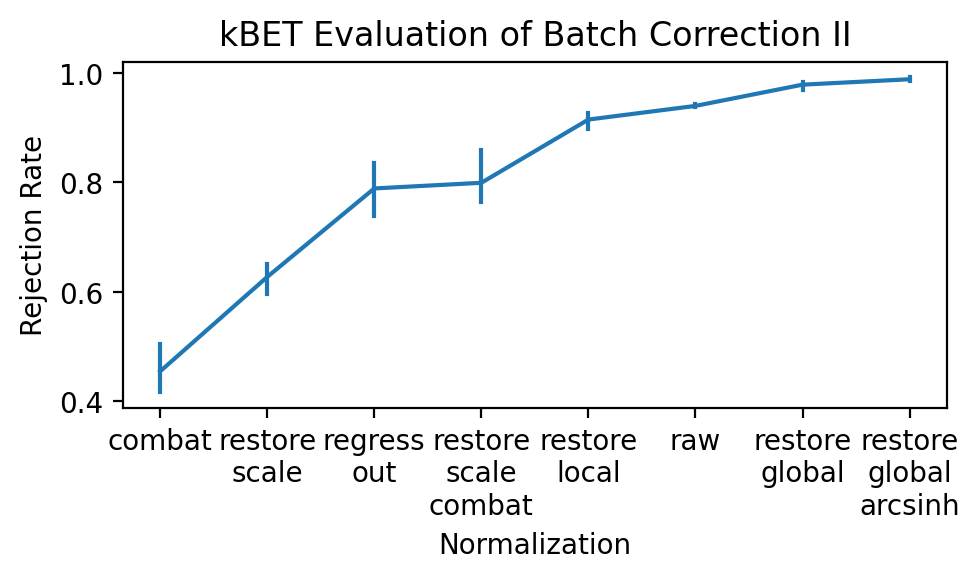

In [20]:
#os.chdir(filterdir)
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
#ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
ls_method = ['raw', 'raw_combat', 'raw_regress_out', 'restore_local', 'restore_div','restore_div_arcsinh', 'restore_scale','restore_scale_combat']#,'raw_restore_combat' 'raw_restore','raw_restore_regress_out',

#add mean kbet
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_method)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,3),dpi=200)
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('raw_','').replace('_','\n').replace('div','global') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0)
ax.set_ylabel('Rejection Rate')
ax.set_xlabel('Normalization')
ax.set_title('kBET Evaluation of Batch Correction II')
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffectII.png',dpi=200)

In [47]:
df_plot.groupby('Norm').mean()

mean_kbet
Norm                          
raw_combat            0.454364
restore_scale         0.626889
raw_regress_out       0.788704
restore_local         0.914633
raw                   0.939605
restore_div           0.978421
restore_div_arcsinh   0.988306

In [48]:
df_plot.groupby('Norm').std()

mean_kbet
Norm                          
raw_combat            0.045267
restore_scale         0.028187
raw_regress_out       0.048837
restore_local         0.015092
raw                   0.002303
restore_div           0.008651
restore_div_arcsinh   0.003616

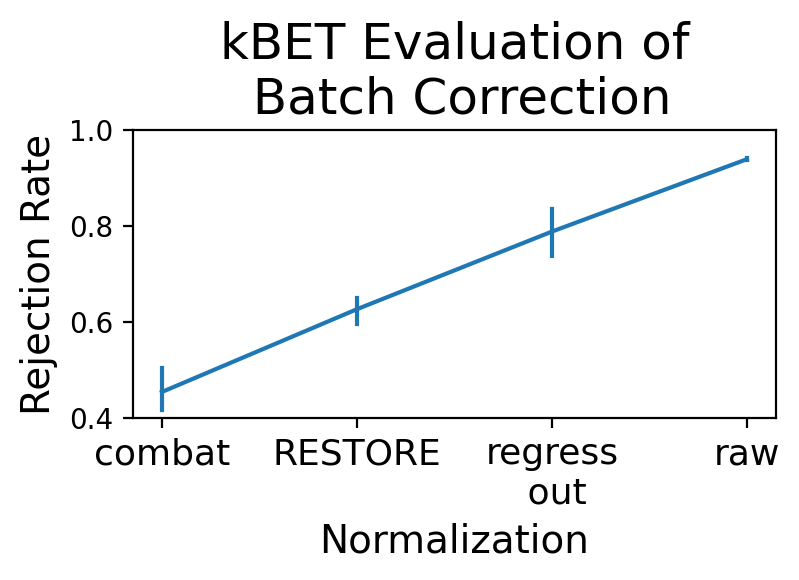

In [49]:
df_select = df_plot[df_plot.Norm.isin(['raw_combat','restore_scale','raw_regress_out','raw'])]
fig, ax = plt.subplots(figsize=(4.1,3),dpi=200)
df_plot = df_select.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = ['combat','RESTORE','regress\n out','raw']
ax.set_xticks(range(len(df_select.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0,fontsize=13)
ax.set_ylabel('Rejection Rate',fontsize=14)
ax.set_xlabel('Normalization',fontsize=14)
ax.set_ylim(.4,1)
ax.set_title('kBET Evaluation of\n Batch Correction', fontsize=18)
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffectII_select.png',dpi=200)

## Training combat with controls: Results

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat? - **No, kbet rejection rate is near 1**
- Can a limited set of tissues be used to fit combat? - **Varies, kbet rejection from 0.85 to 1, depending on training tissue**
- Or, should the set of tissues used to fit combat be very similar to those it is applied to? - **Yes, lowest kbet rejection rate**

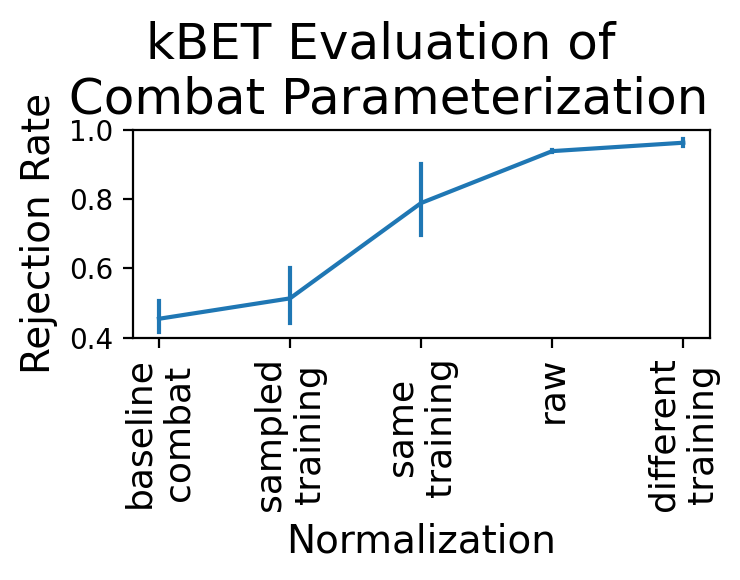

In [15]:
#add mean kbet
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_train)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.8,3),dpi=200)
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('raw_','baseline_').replace('_','\n').replace('train','training').replace('diff','different') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=90,fontsize=13)
ax.set_ylabel('Rejection Rate',fontsize=14)
ax.set_xlabel('Normalization',fontsize=14)
ax.set_ylim(.4,1)
ax.set_title('kBET Evaluation of\n Combat Parameterization',fontsize=18,x=.43)
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffect_CombatParam.png',dpi=200)

In [13]:
df_plot.groupby('Norm').mean()

mean_kbet
Norm                    
raw_combat      0.454364
sampled_train   0.514080
same_train      0.789463
raw             0.939605
diff_train      0.963981

In [37]:
df_plot.groupby('Norm').std()

mean_kbet
Norm                    
raw_combat      0.045267
sampled_train   0.063714
same_train      0.068492
raw             0.002303
diff_train      0.008947

In [18]:
df_file.sort_values('Norm')

mean_kbet           norm  \
20201207_BM-Her2N75-15-17-18_kbet_raw_combat.csv     0.416722     raw_combat   
20201209_BM-Her2N75-15-17-18_kbet_raw_combat.csv     0.441778     raw_combat   
20201208_BM-Her2N75-15-17-18_kbet_raw_combat.csv     0.504593     raw_combat   
20210301-2_BM-Her2N75-15-17-18_kbet_sampled_tra...   0.441222  sampled_train   
20210301-0_BM-Her2N75-15-17-18_kbet_sampled_tra...   0.497500  sampled_train   
20210301-1_BM-Her2N75-15-17-18_kbet_sampled_tra...   0.601611  sampled_train   
20210301-1_BM-Her2N75-15-17-18_kbet_same_train.csv   0.698315     same_train   
20210301-0_BM-Her2N75-15-17-18_kbet_same_train.csv   0.902389     same_train   
20210301-2_BM-Her2N75-15-17-18_kbet_same_train.csv   0.767685     same_train   
20201207_BM-Her2N75-15-17-18_kbet_raw.csv            0.938593            raw   
20201208_BM-Her2N75-15-17-18_kbet_raw.csv            0.937981            raw   
20201209_BM-Her2N75-15-17-18_kbet_raw.csv            0.942241            raw   
20210301-0_BM-Her2N75-15-17-18_kbet_diff_train.csv   0.975907     diff_train   
20210301-1_BM-Her2N75-15-17-18_kbet_diff_train.csv   0.953907     diff_train   
20210301-2_BM-Her2N75-15-17-18_kbet_diff_train.csv   0.962130     diff_train   

                                                             Norm  
20201207_BM-Her2N75-15-17-18_kbet_raw_combat.csv       raw_combat  
20201209_BM-Her2N75-15-17-18_kbet_raw_combat.csv       raw_combat  
20201208_BM-Her2N75-15-17-18_kbet_raw_combat.csv       raw_combat  
20210301-2_BM-Her2N75-15-17-18_kbet_sampled_tra...  sampled_train  
20210301-0_BM-Her2N75-15-17-18_kbet_sampled_tra...  sampled_train  
20210301-1_BM-Her2N75-15-17-18_kbet_sampled_tra...  sampled_train  
20210301-1_BM-Her2N75-15-17-18_kbet_same_train.csv     same_train  
20210301-0_BM-Her2N75-15-17-18_kbet_same_train.csv     same_train  
20210301-2_BM-Her2N75-15-17-18_kbet_same_train.csv     same_train  
20201207_BM-Her2N75-15-17-18_kbet_raw.csv                     raw  
20201208_BM-Her2N75-15-17-18_kbet_raw.csv                     raw  
20201209_BM-Her2N75-15-17-18_kbet_raw.csv                     raw  
20210301-0_BM-Her2N75-15-17-18_kbet_diff_train.csv     diff_train  
20210301-1_BM-Her2N75-15-17-18_kbet_diff_train.csv     diff_train  
20210301-2_BM-Her2N75-15-17-18_kbet_diff_train.csv     diff_train

In [19]:
ls_index = [ '20201208_BM-Her2N75-15-17-18_SampledMeanIntensity_raw.csv',
 '20210301-2_BM-Her2N75_SampledMeanIntensity_same_train.csv',
 '20210301-2_BM-Her2N75_SampledMeanIntensity_diff_train.csv',
 '20210301-0_BM-Her2N75_SampledMeanIntensity_sampled_train.csv',
 '20201209_BM-Her2N75-15-17-18_SampledMeanIntensity_raw_combat.csv'
]

In [20]:

marker_genes = ['CD44', 'CD45', 'CD4', 'CD68', 'CK14', 'CK19', 'CK5', 'CK7', 'ER',
       'Ecad', 'Ki67', 'PD1', 'Vim', 'aSMA', 'pHH3']
d_je_tma = {'scene01':'tonsil1','scene02':'HCC1143', 'scene03':'HCC3153', 'scene04':'NBreast',
    'scene05':'T47D','scene06':'T47D','scene07':'tonsil2','scene08':'BT474','scene09':'BT474','scene10':'AU565',
    'scene11':'AU565','scene12':'MDAMB-436','scene13':'MDAMB-436' }
d_je_tma = {'scene017': 'ER-HER2-imm',
  'scene049': 'ER-HER2',
  'scene059': 'HER2-imm'}

20201208_BM-Her2N75-15-17-18_SampledMeanIntensity_raw.csv


... storing 'batch' as categorical
... storing 'scene' as categorical


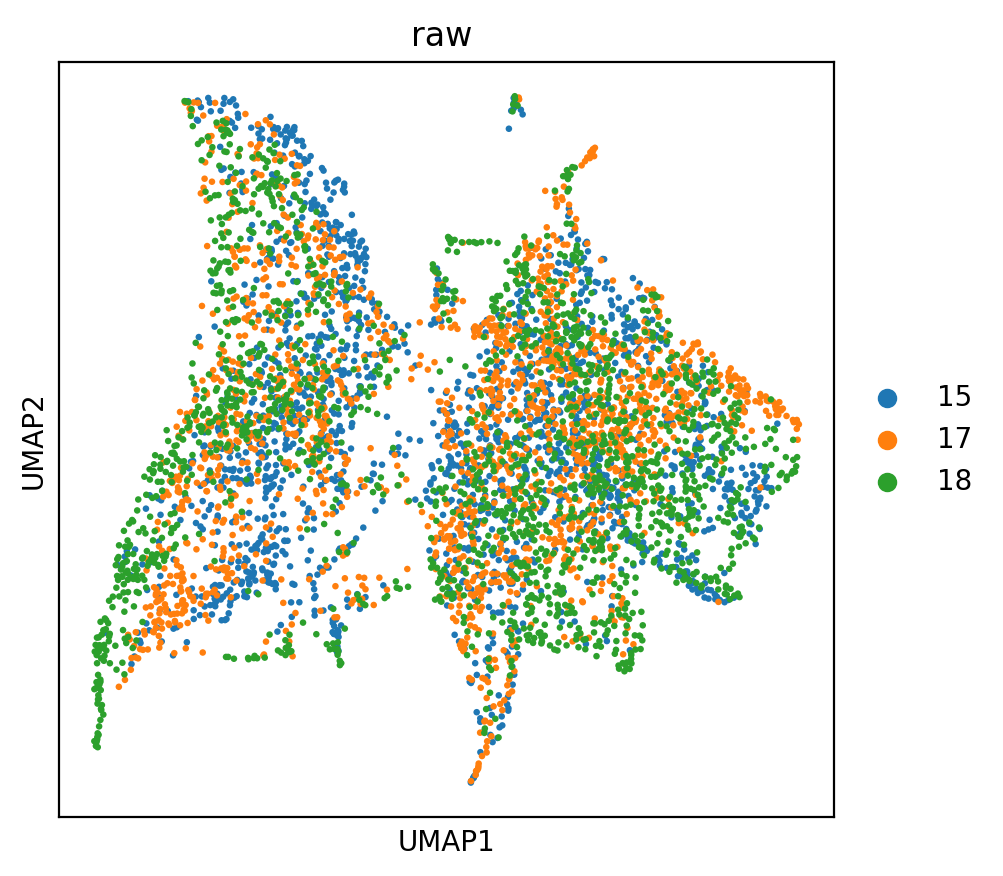

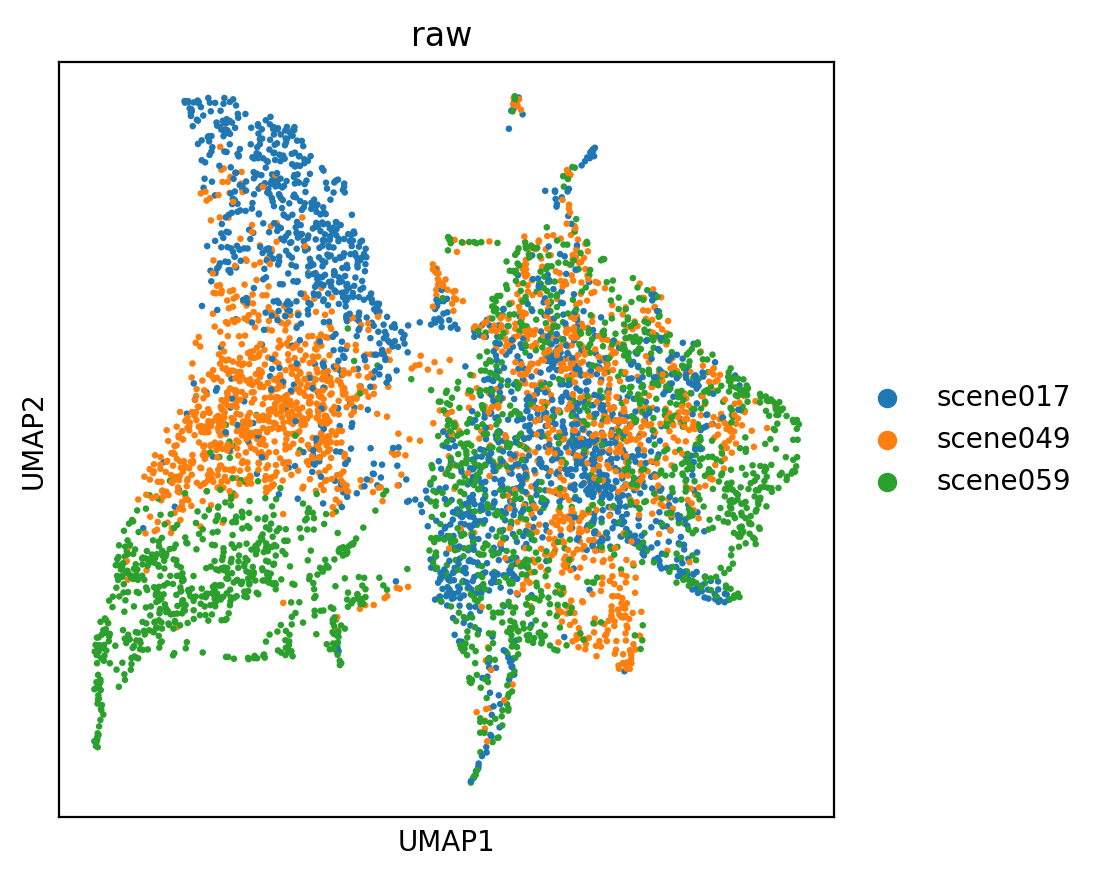

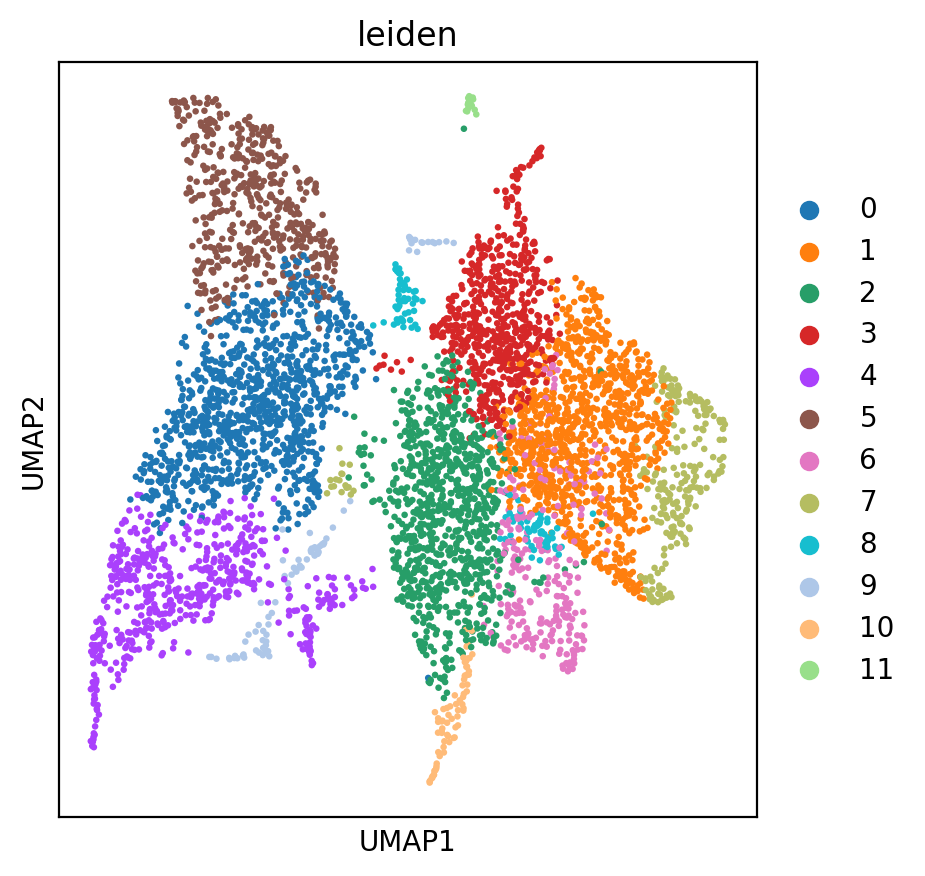

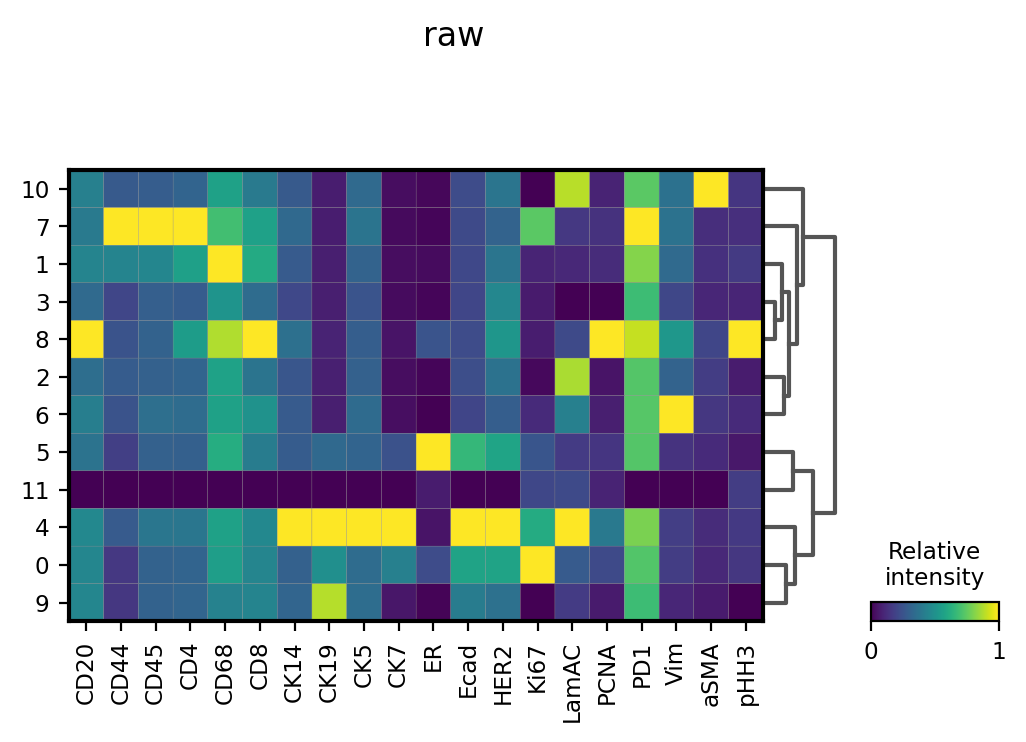

0.9466761433491485
20210301-2_BM-Her2N75_SampledMeanIntensity_same_train.csv


... storing 'batch' as categorical
... storing 'scene' as categorical


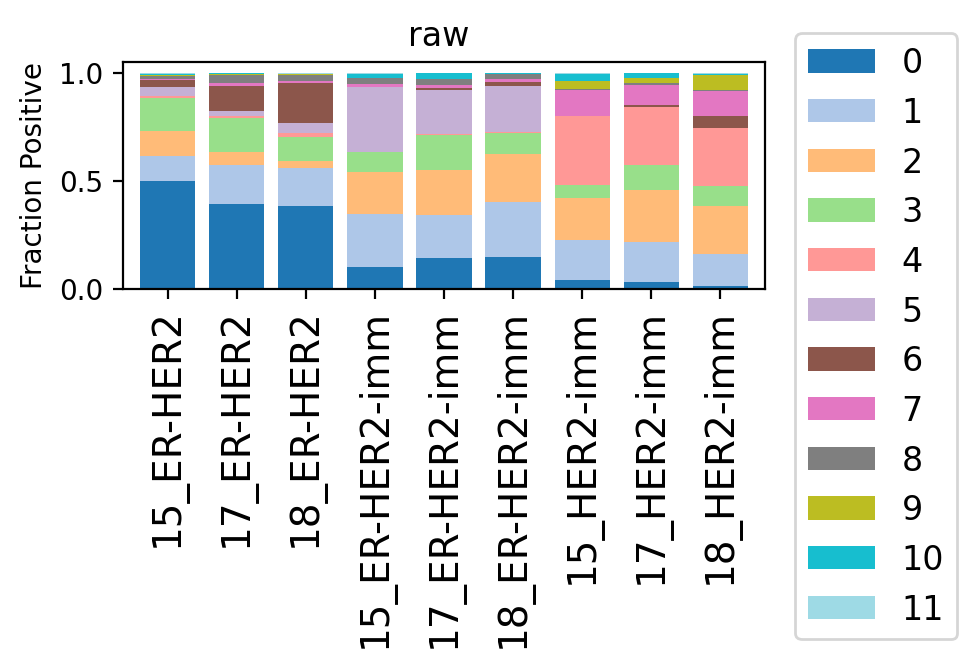

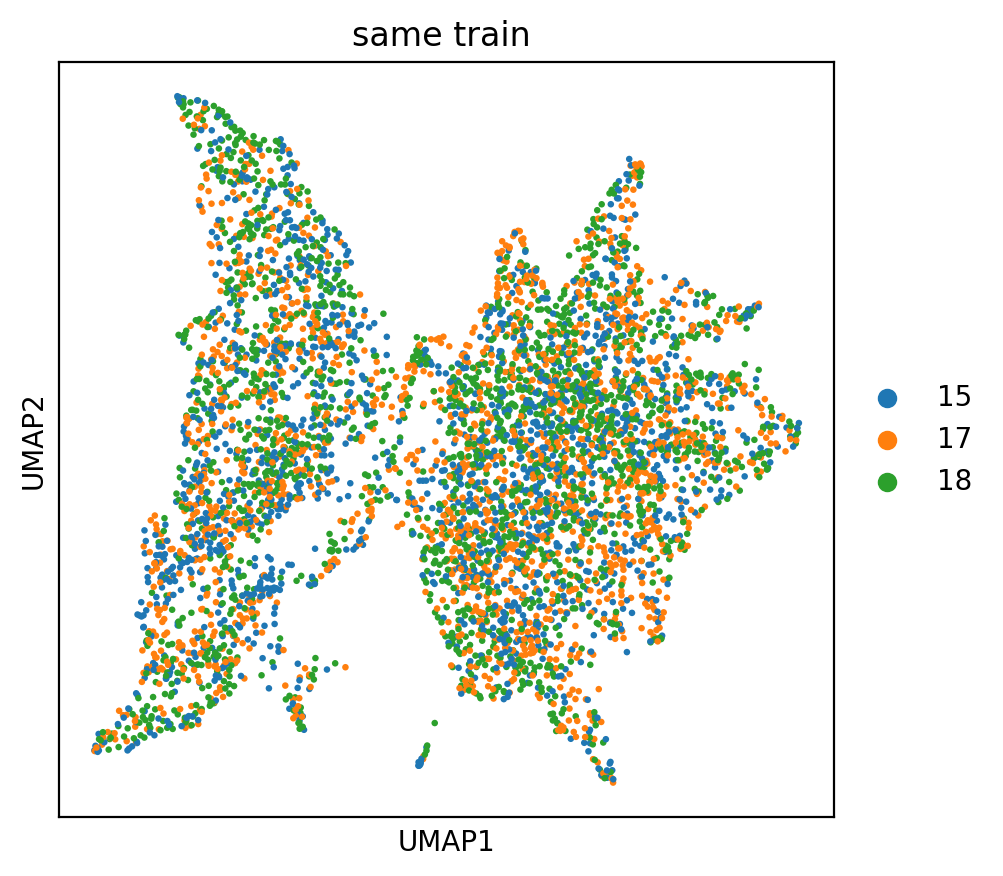

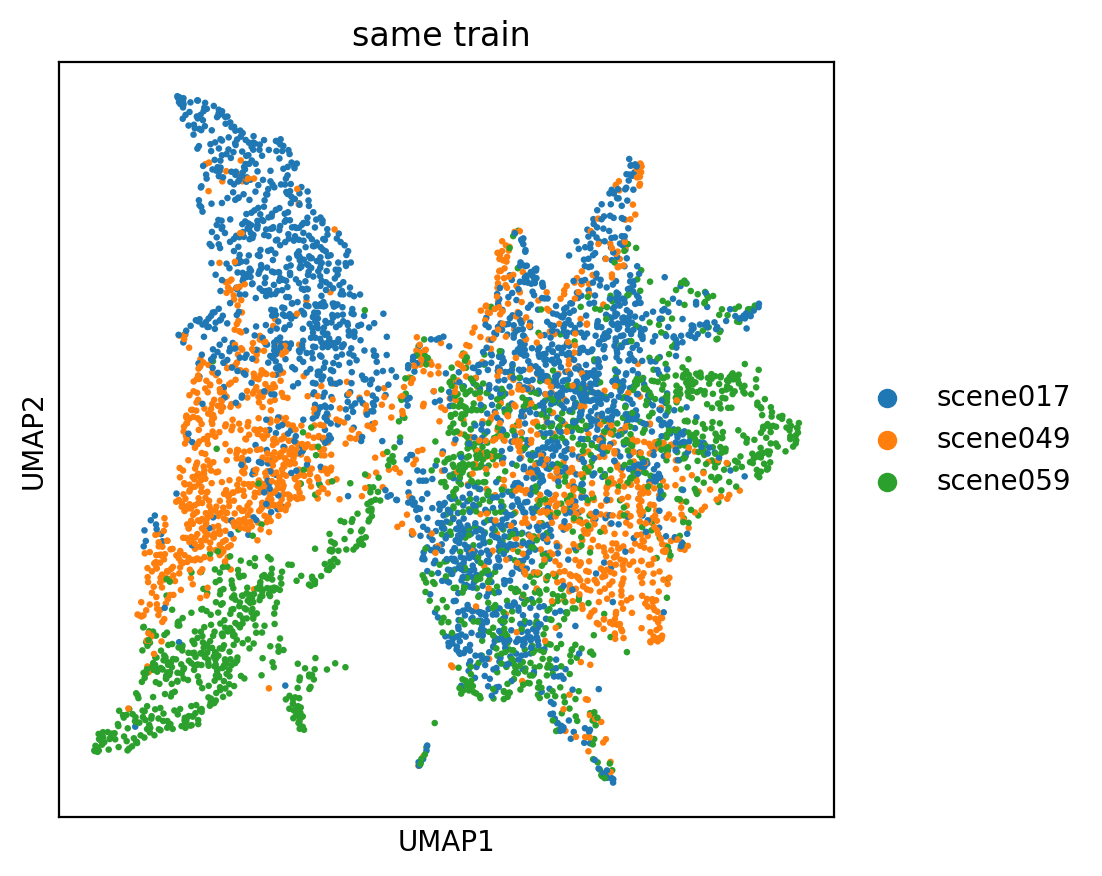

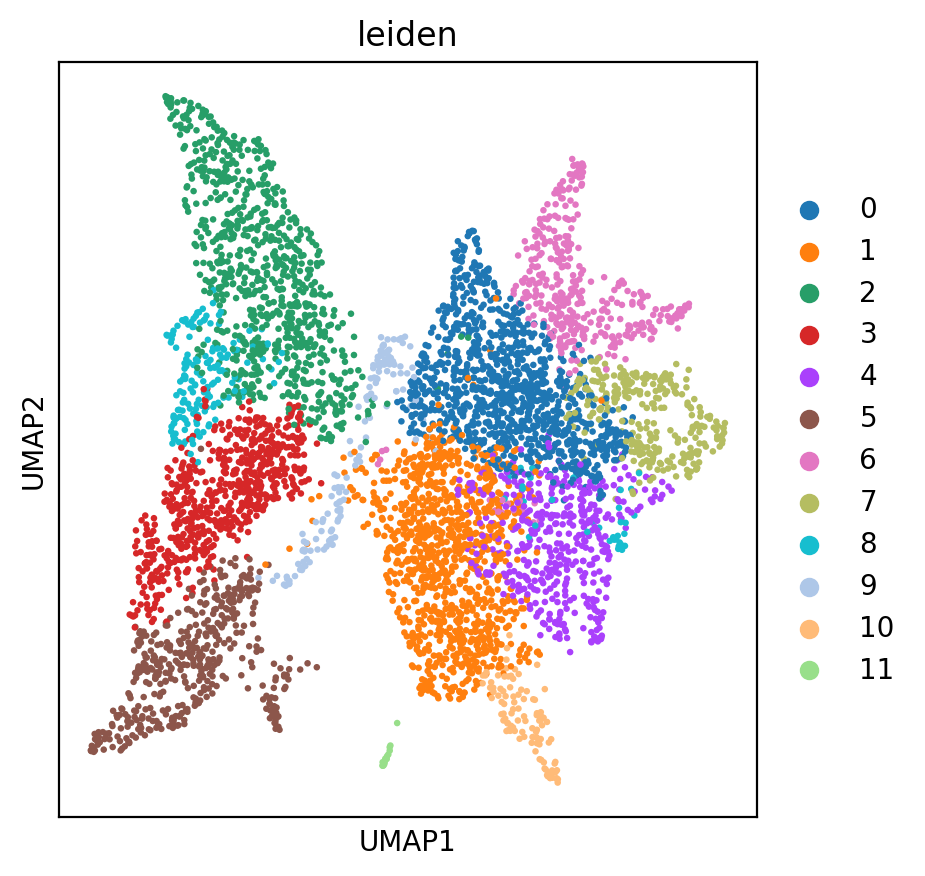

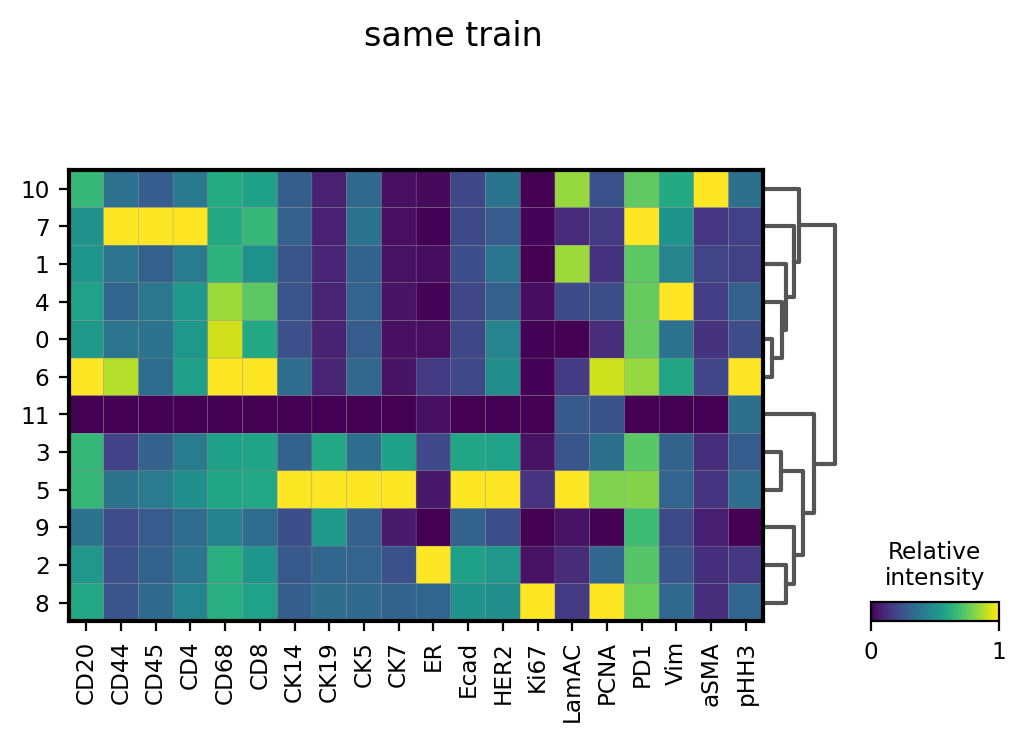

0.9666057747285228
20210301-2_BM-Her2N75_SampledMeanIntensity_diff_train.csv


... storing 'batch' as categorical
... storing 'scene' as categorical


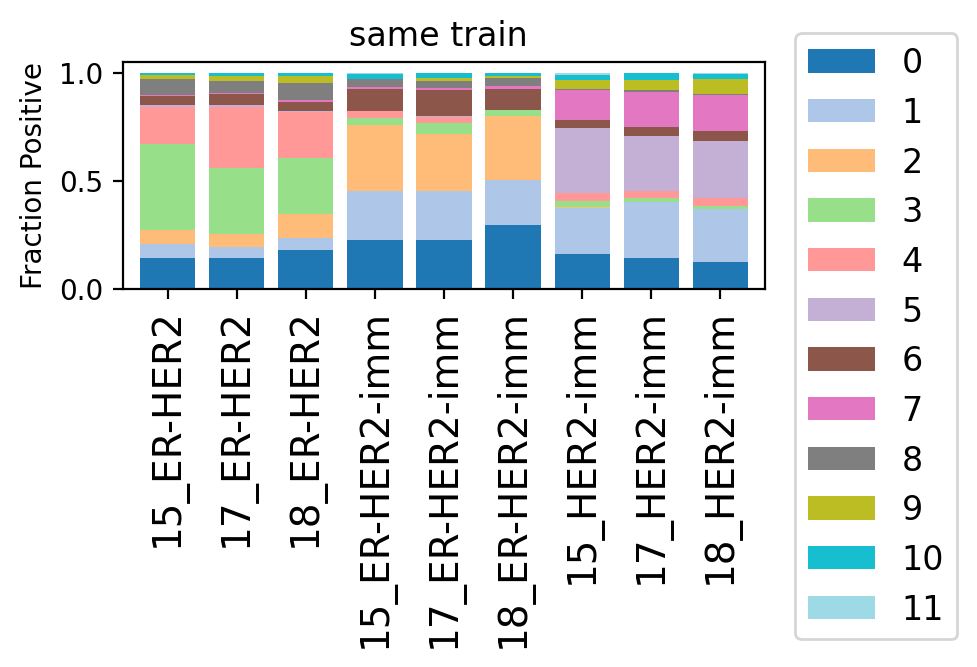

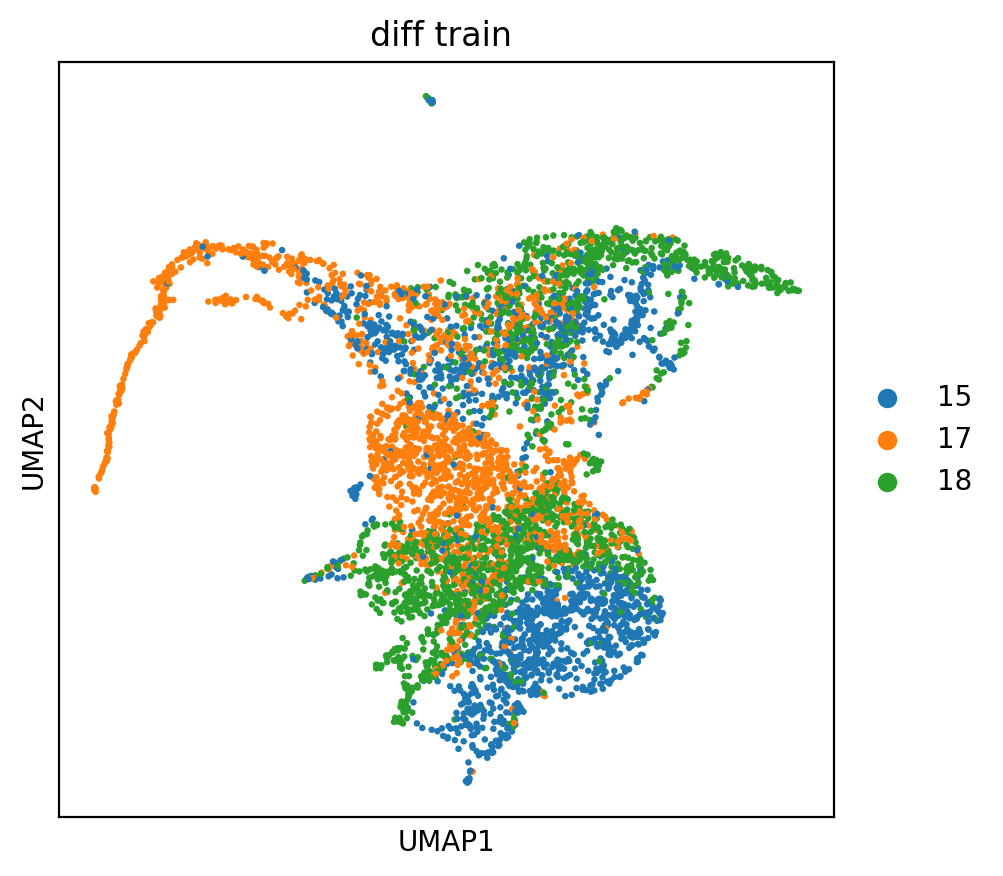

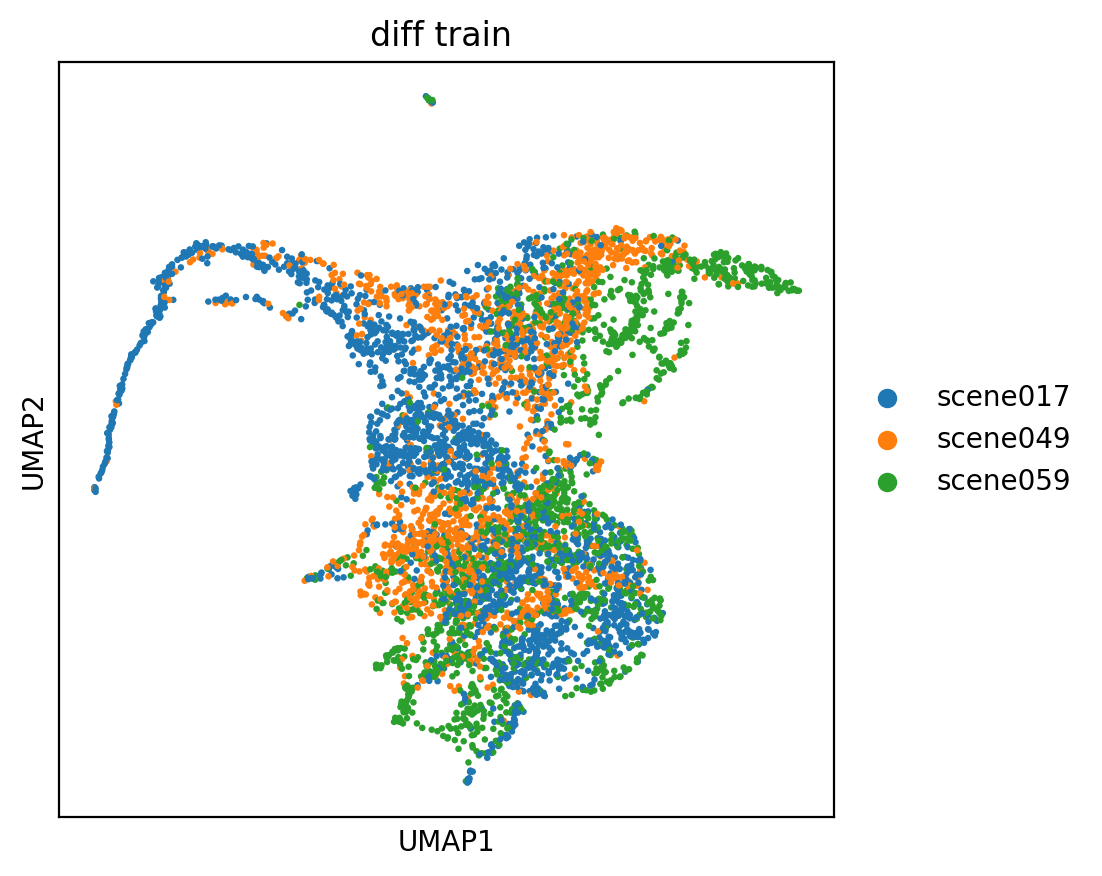

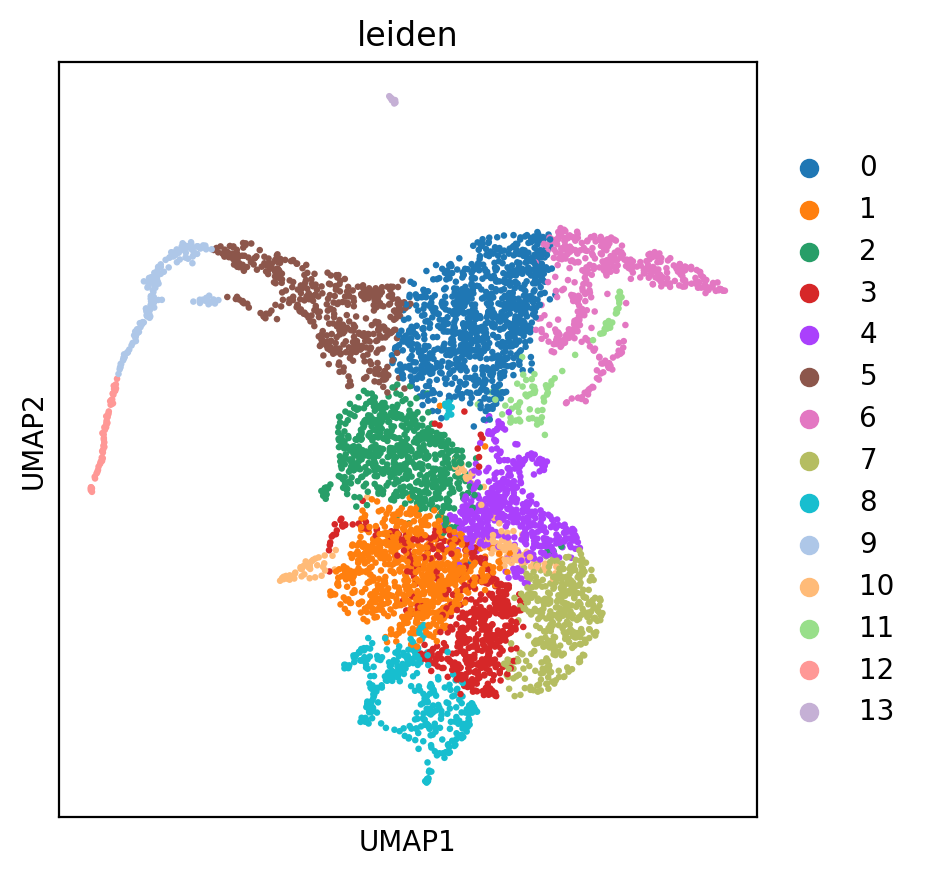

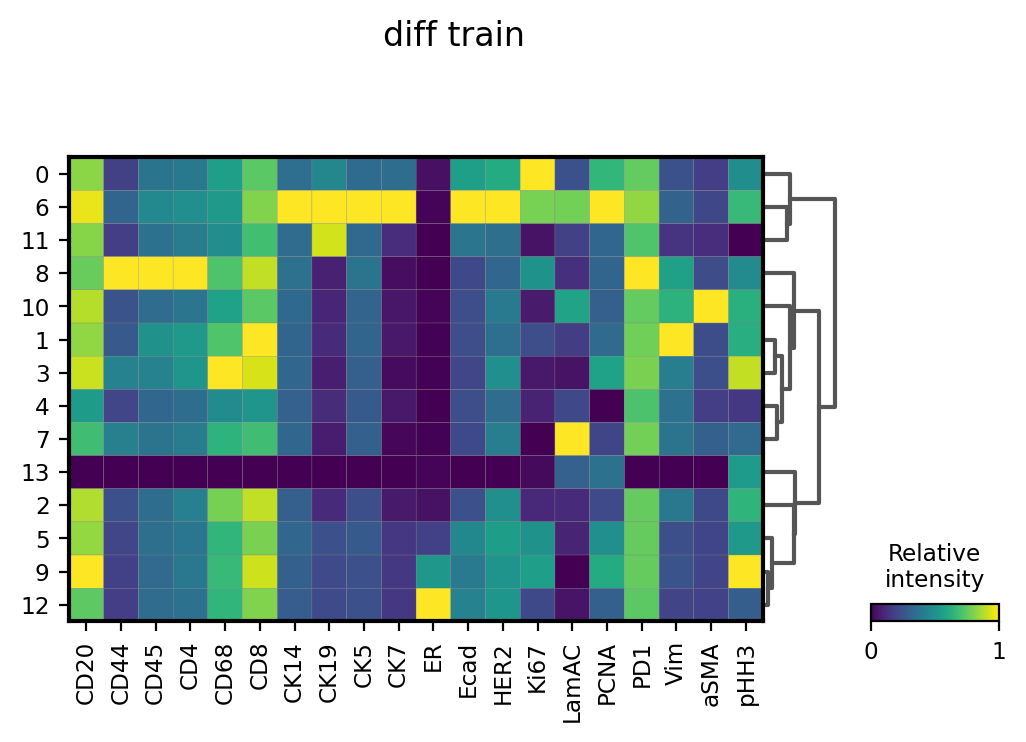

0.17960837316302627
20210301-0_BM-Her2N75_SampledMeanIntensity_sampled_train.csv


... storing 'batch' as categorical
... storing 'scene' as categorical


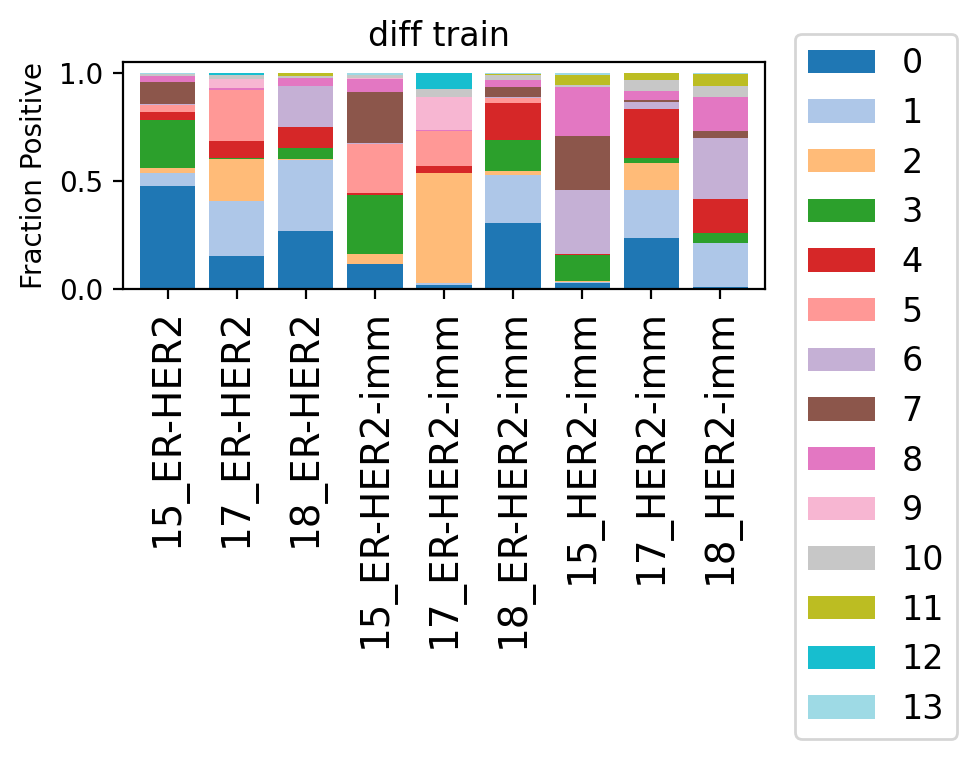

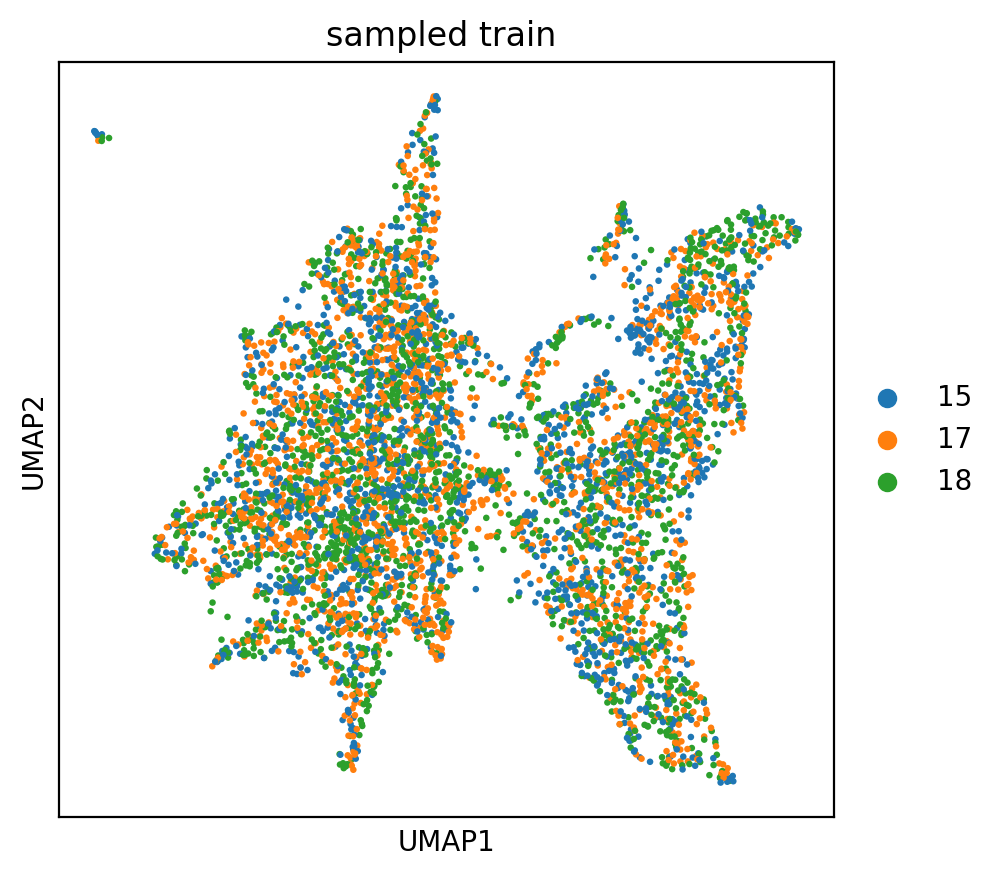

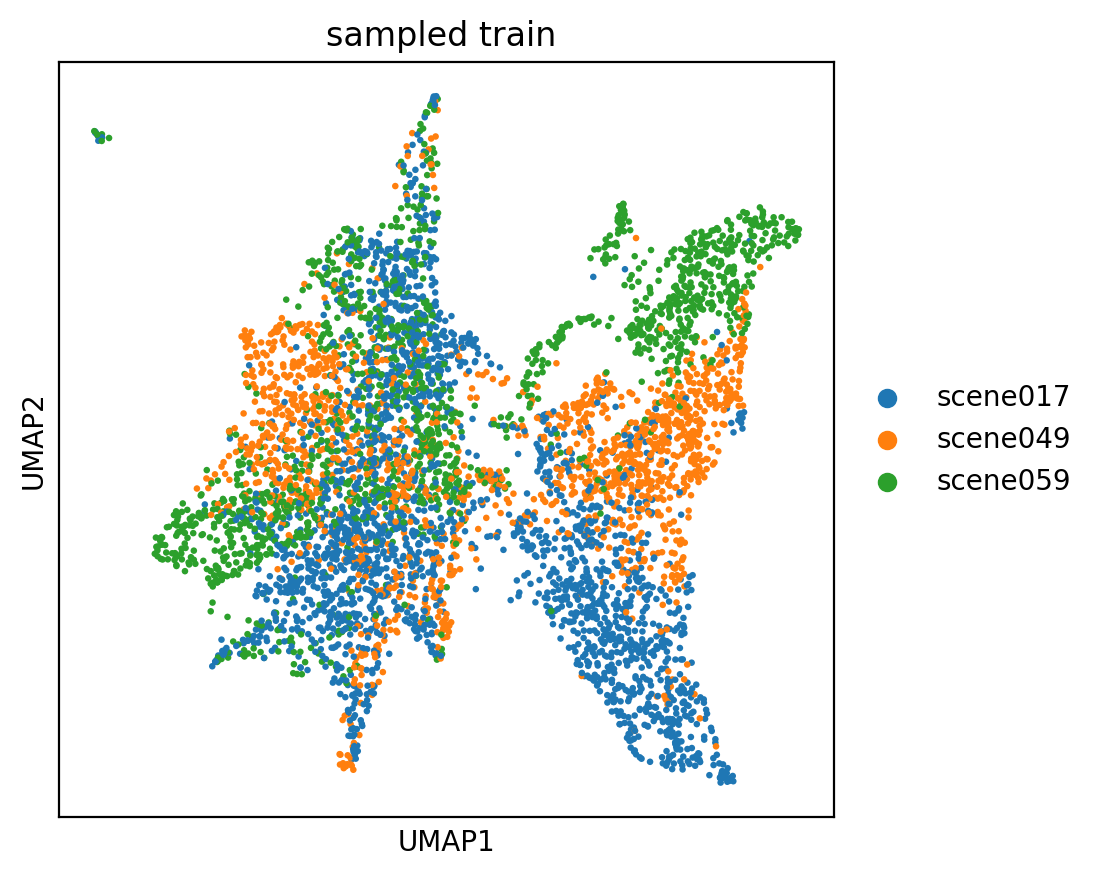

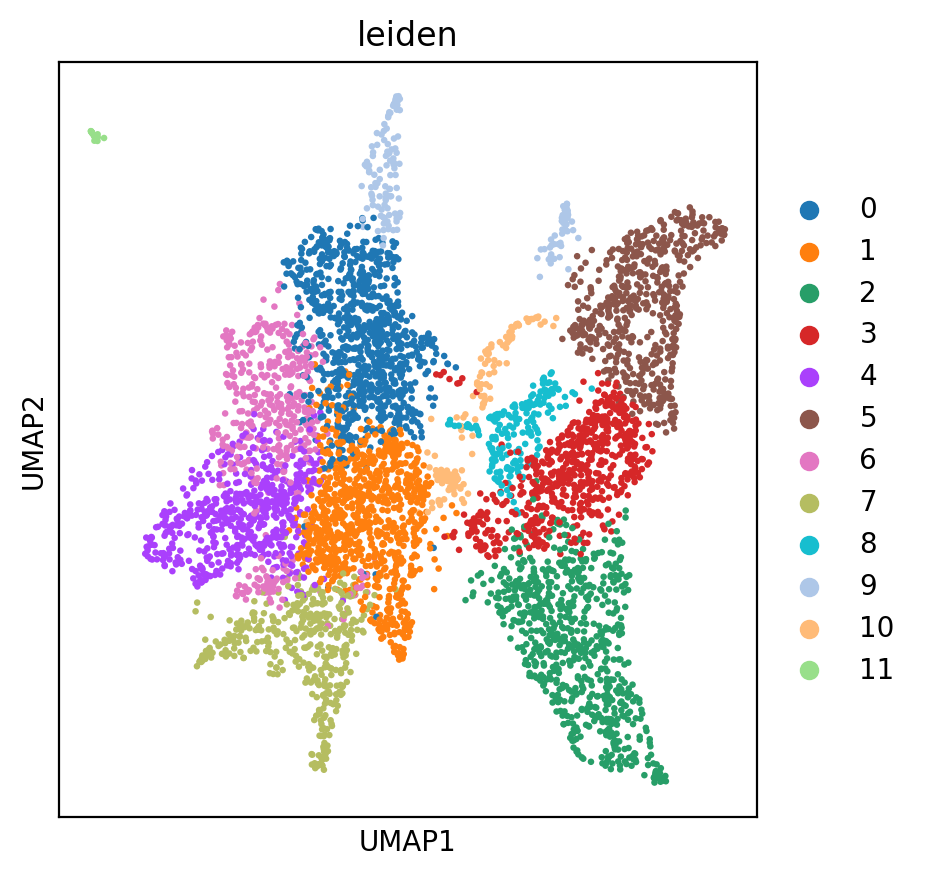

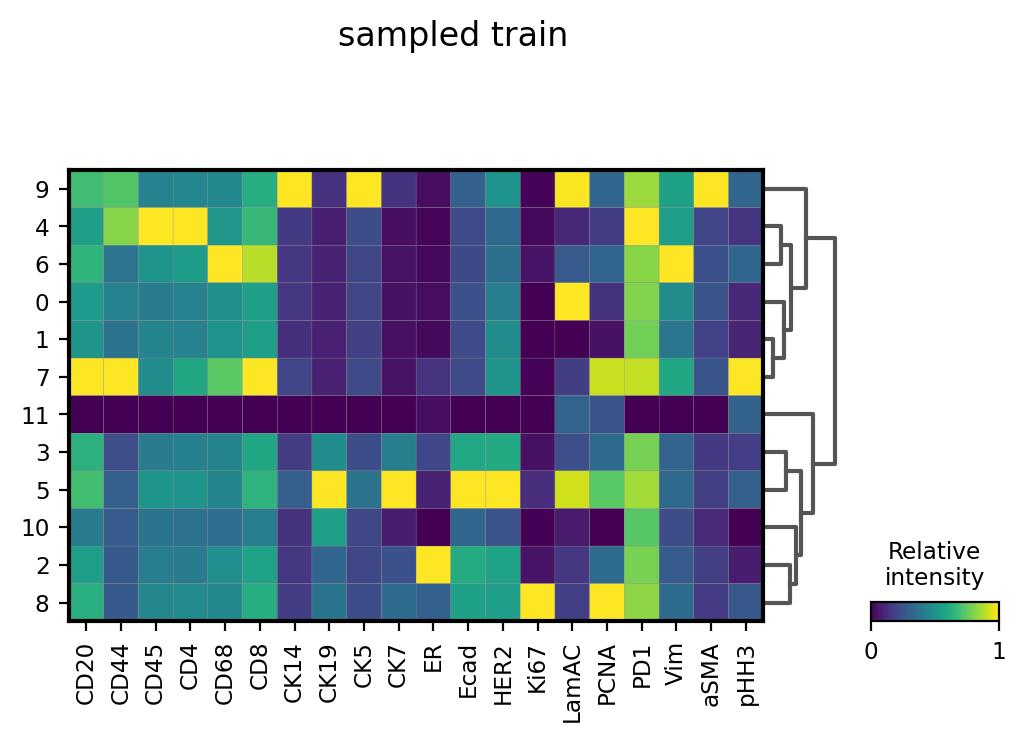

0.9704311281918367
20201209_BM-Her2N75-15-17-18_SampledMeanIntensity_raw_combat.csv


... storing 'batch' as categorical
... storing 'scene' as categorical


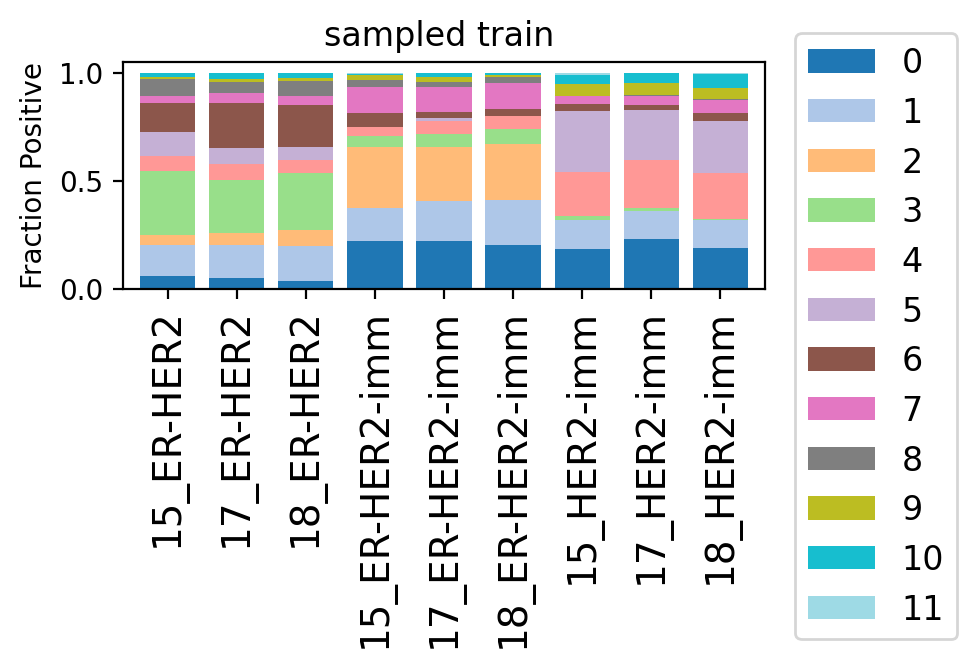

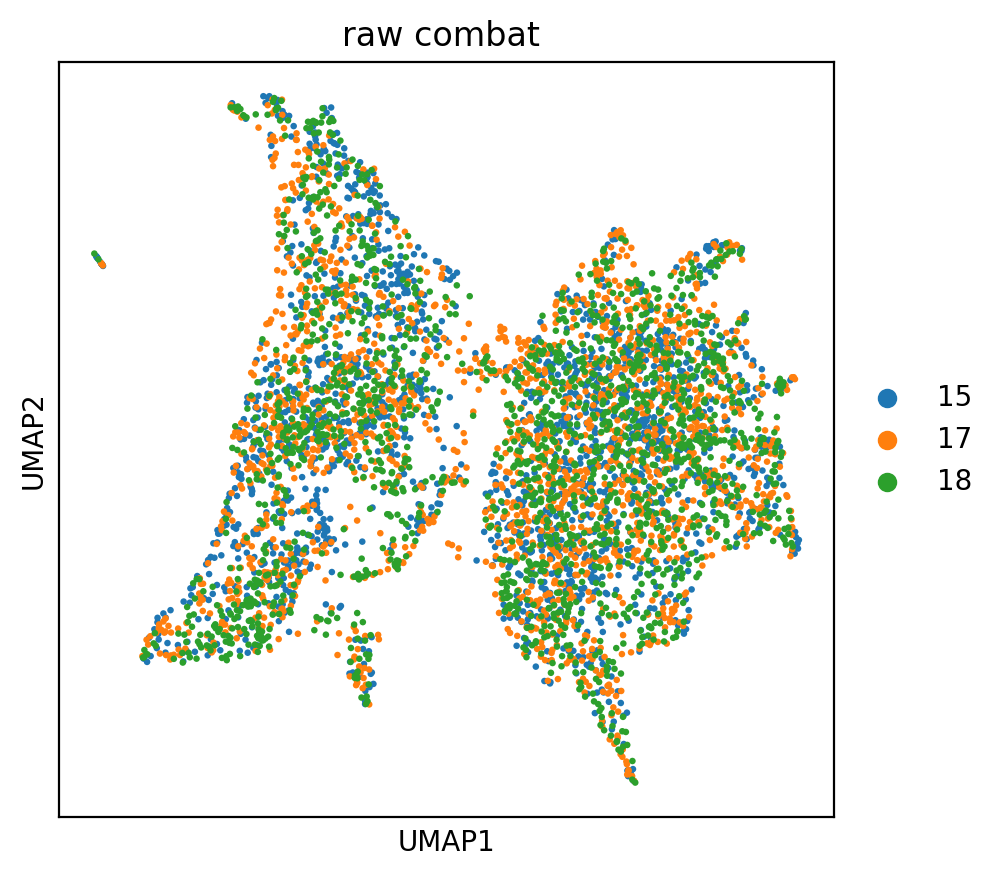

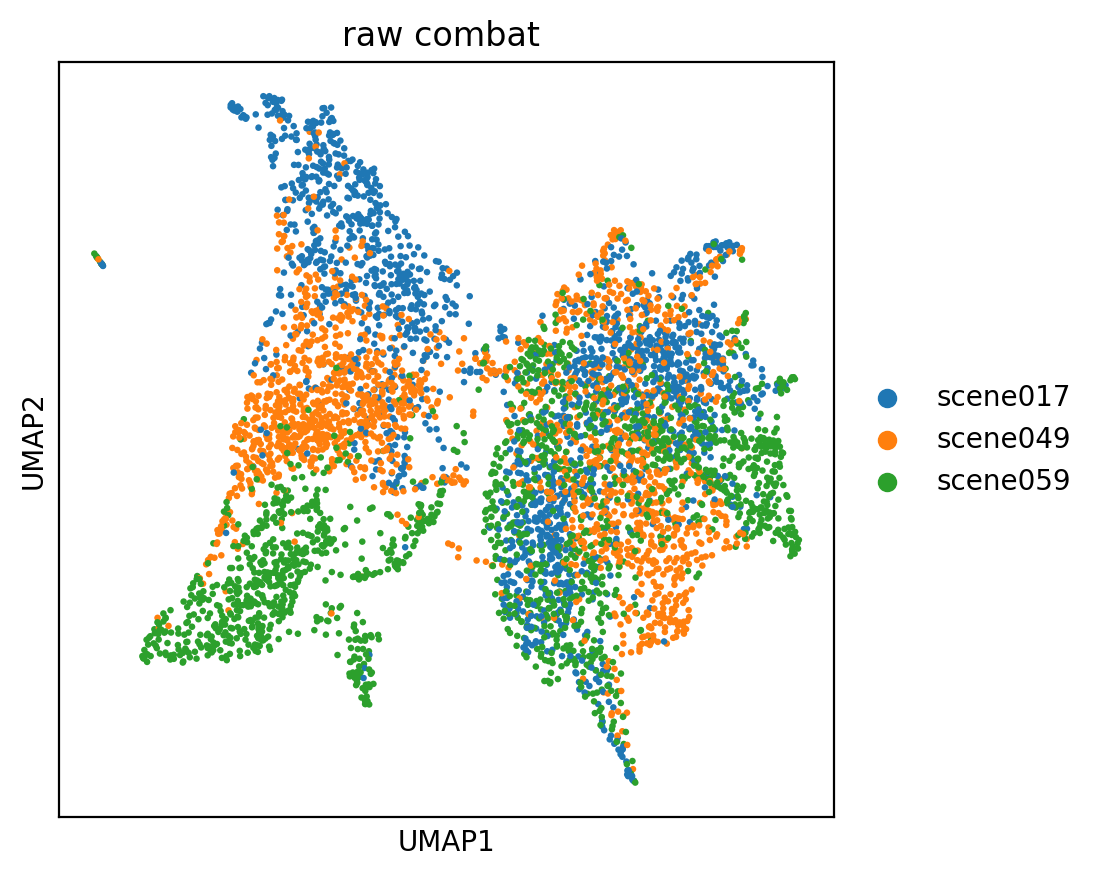

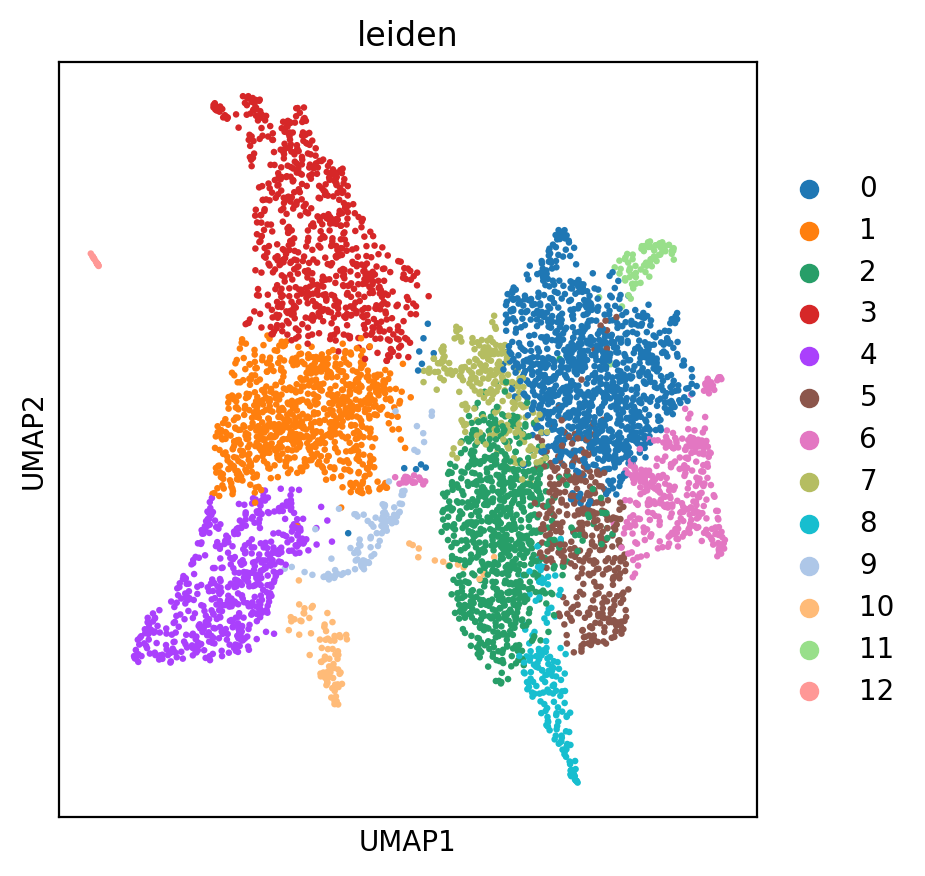

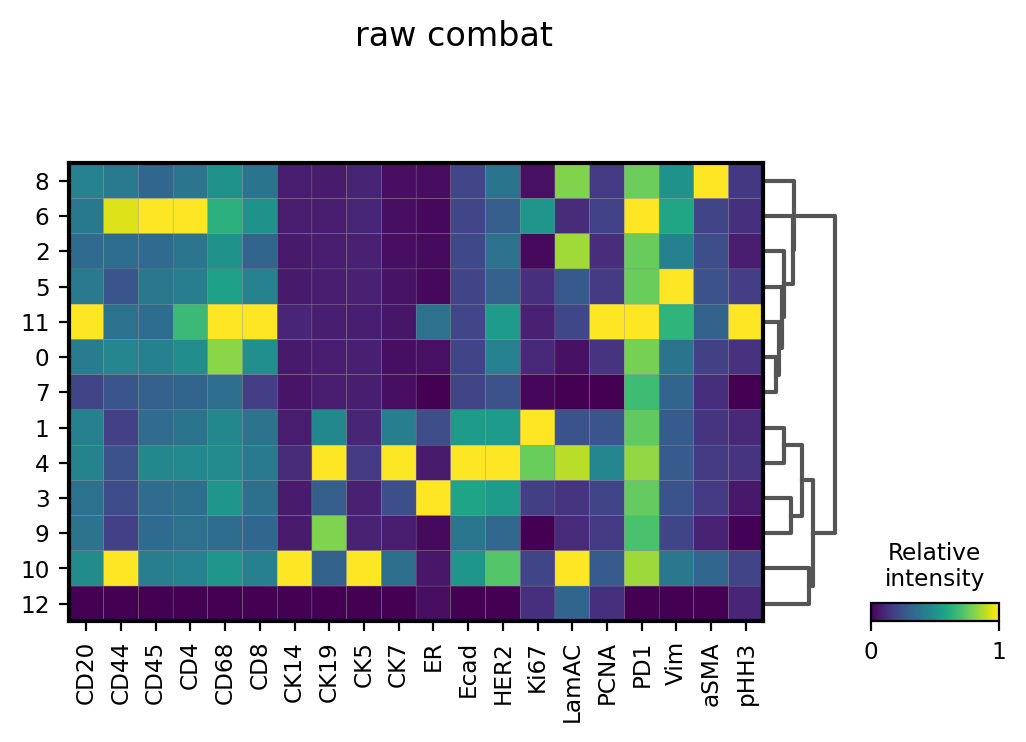

0.9760863220796112


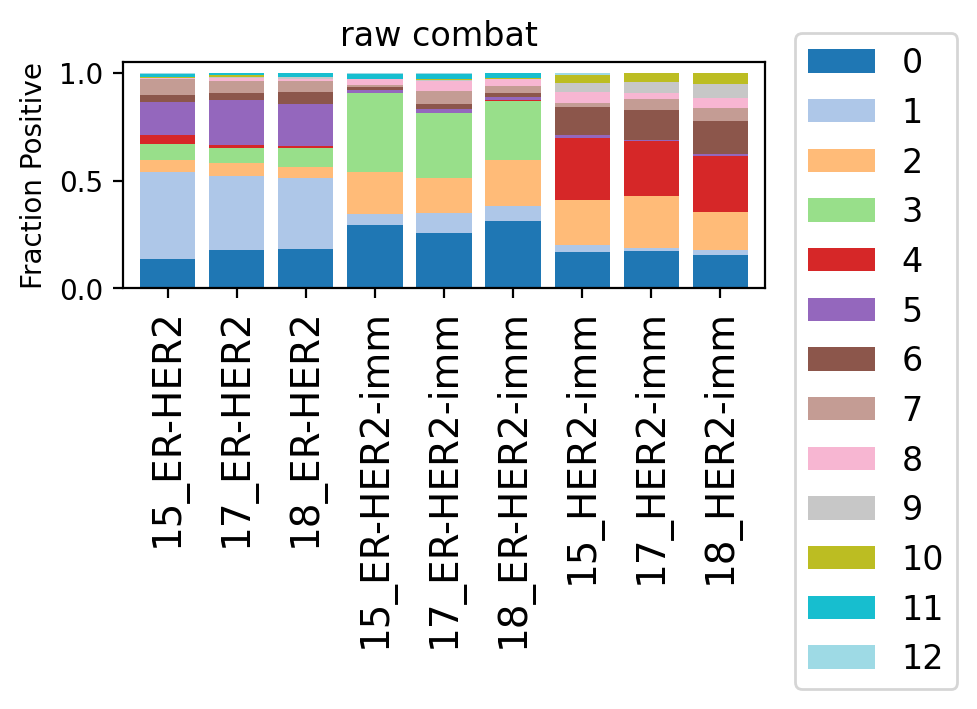

In [56]:
# normalize 
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
%matplotlib inline
#sc.set_figure_params(scanpy=True, fontsize=14)
df_pearson = pd.DataFrame()
for s_index in ls_index:
    print(s_index)
    df = pd.read_csv(s_index,index_col=0)
    df.columns = [item.split('_')[0] for item in df.columns]
    marker_genes = df.columns[df.dtypes=='float64'].tolist()
    adata = sc.AnnData(df.loc[:,df.dtypes=='float64'])
    adata.obs['batch'] = [item.split('_scene')[0].split('BM-Her2N75-')[1] for item in adata.obs.index]
    adata.obs['scene'] = [item.split('_')[1] for item in adata.obs.index]
    s_norm = ''#s_index.split('SampledMeanIntensity_')[1].split('.')[0]
    adata.raw = adata
    #reduce dimensionality
    sc.tl.pca(adata, svd_solver='auto')
    #save normalized data
    df = pd.DataFrame(data=adata.X,index=adata.obs.index,columns=adata.var.index)
    df['batch'] = [item.split('_scene')[0] for item in df.index]
    #df.to_csv(f'{s_index.replace(".csv",f"_{s_norm}.csv")}')
    # calculate neighbors     
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
    sc.tl.umap(adata)
    #umap plot
    s_type = s_index.split('SampledMeanIntensity_')[1].split('.')[0]
    figname = f"UmapBatch_param_{s_type}_{s_norm}.png"
    fig,ax = plt.subplots(figsize=(5,5), dpi=200)
    sc.pl.umap(adata, color='batch',title=f"{s_type.replace('_',' ')} {s_norm}",wspace=.25,ax=ax,save=figname)
    fig,ax = plt.subplots(figsize=(5,5), dpi=200)
    figname = f'UmapScene_param_{s_type}_{s_norm}.png'
    fig = sc.pl.umap(adata, color='scene',save=figname,ax=ax,title=f"{s_type.replace('_',' ')} {s_norm}")
    X_pca = adata.obsm['X_pca'] 
    #leiden
    #resolution=0.25
    resolution=0.4
    #resolution=0.6
    sc.tl.leiden(adata,resolution=resolution)
    fig,ax = plt.subplots(figsize=(4.5,5),dpi=200)
    figname=f'leiden_param_{s_type}_{s_norm}{resolution}.png'
    sc.pl.umap(adata, color='leiden',ax=ax,save=figname)
    fig,ax = plt.subplots(figsize=(6,3.7), dpi=200)
    figname=f'Matrixplot_param_leiden_{s_type}_{s_norm}{resolution}.png'
    sc.pl.matrixplot(adata, var_names=marker_genes, groupby=f'leiden',title=s_type.replace('_',' '),
                     dendrogram=True,ax=ax,save=figname,standard_scale='var',colorbar_title='Relative\nintensity')
    df = pd.DataFrame(data=adata.raw.X,index=adata.obs.index,columns=adata.var.index)
    df['leiden'] = adata.obs['leiden']
    #stacked bar
    s_trans = s_index.split('Intensity_')[1].split('.')[0]
    df['slide'] = [item.split('_')[0] for item in df.index]
    df['scene'] = [d_je_tma[item.split('_')[1]] for item in df.index]
    df['slide_scene'] = df.slide + '_' + df.scene
    df_prop = (df.groupby([f'leiden','slide_scene']).CD4.count())/(df.groupby(['slide_scene']).CD4.count())
    df_prop = df_prop.unstack().fillna(value=0).T
    #barplot
    fig,ax=plt.subplots(figsize=(5,3.7), dpi=200)
    df_prop.columns = df_prop.columns.add_categories(['slide','scene'])
    df_prop.index = [item.replace('BM-Her2N75-','') for item in df_prop.index]
    df_prop['slide'] =[item.split('_')[0] for item in df_prop.index]
    df_prop['scene'] =[item.split('_')[1] for item in df_prop.index]
    df_prop.sort_values(['scene','slide']).plot(kind='bar',stacked=True,ax=ax,legend=True,cmap='tab20',width=.8)
    ax.legend(bbox_to_anchor=(1.02, 1.2), ncol=1,fontsize=12)
    ax.set_ylabel('Fraction Positive')
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_title(f"{s_trans.replace('_',' ')} {s_norm}")
    ax.grid(False)
    plt.tight_layout()
    fig.savefig(f'./figures/StackedBar_param_{s_trans}_{s_norm}{resolution}_Leiden.png')
    #pearson
    ls_core = sorted(set(df_prop.scene))
    se_all = pd.Series(dtype='float64',name=s_trans)
    for s_core in ls_core:
        test = df_prop.loc[df_prop.scene==s_core,df_prop.dtypes=='float64']
        se_test = pd.Series([scipy.stats.pearsonr(test.iloc[0],test.iloc[1])[0],scipy.stats.pearsonr(test.iloc[1],test.iloc[2])[0],scipy.stats.pearsonr(test.iloc[2],test.iloc[0])[0]])
        se_all = se_all.append(se_test)
    print(se_all.mean())
    se_all.name = s_trans
    se_all.index = (range(len(se_all)))
    df_pearson = df_pearson.append(se_all)
    #break

In [57]:
#df_pearson.to_csv(f'20210301_Pearson_correlation_param{resolution}.csv')

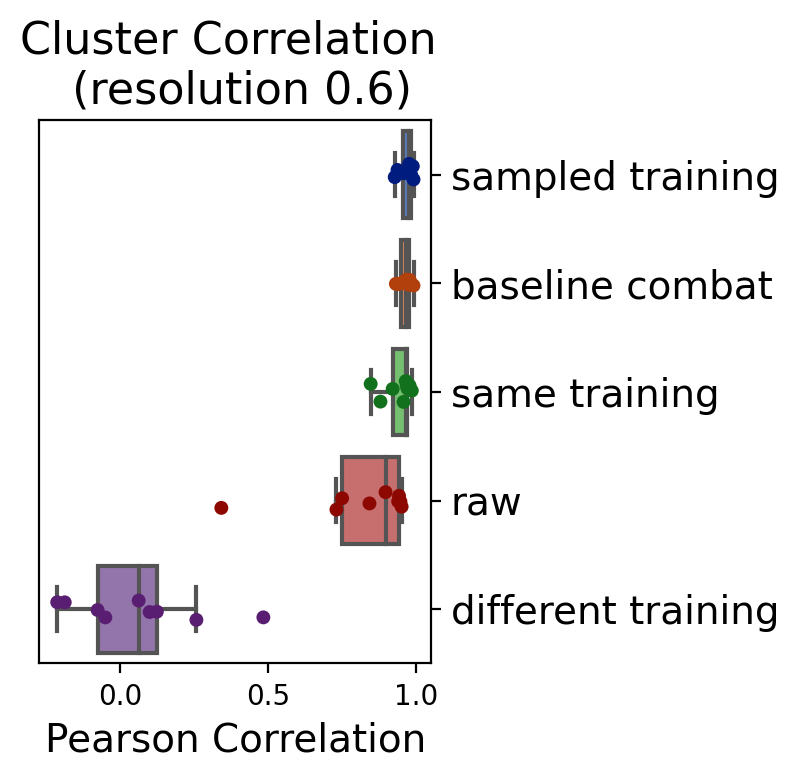

In [35]:
resolution = 0.6
#df_pearson.to_csv(f'Pearson_correlation_param{resolution}.csv')
df_pearson = pd.read_csv(f'20210301_Pearson_correlation_param{resolution}.csv',index_col=0)
ls_order = df_pearson.mean(axis=1).sort_values(ascending=False).index.tolist()
%matplotlib inline
s_date = '20201228'
fig,ax = plt.subplots(figsize=(4,4),dpi=200)
sns.boxplot(data=df_pearson.loc[ls_order].T,ax=ax,orient='h',showfliers=False,palette='muted')
sns.stripplot(data=df_pearson.loc[ls_order].T,ax=ax,orient='h',palette='dark')
ax.set_title(f'Cluster Correlation \n (resolution {resolution})',fontsize=16)
ax.set_xlabel('Pearson Correlation',fontsize=14)
if resolution == 0.6:
    #pass
    ax.set_yticklabels(['sampled training','baseline combat','same training','raw','different training'],fontsize=14)
else:
    ax.set_yticklabels(['baseline combat','same training','raw','sampled training','different training'],fontsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.tight_layout()
fig.savefig(f'{rootdir}/{s_date}/PearsonCorrelation_param{resolution}.png',dpi=200)

In [36]:
df_pearson.mean(axis=1)

raw              0.814853
same_train       0.940512
diff_train       0.054621
sampled_train    0.967393
raw_combat       0.962796
dtype: float64

In [37]:
df_pearson.std(axis=1)

raw              0.196977
same_train       0.048697
diff_train       0.220977
sampled_train    0.022910
raw_combat       0.019999
dtype: float64

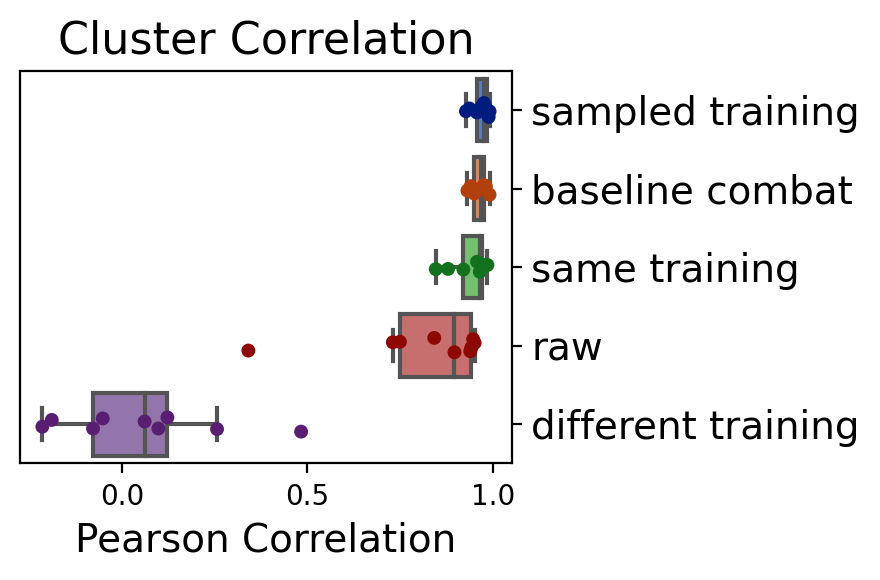

In [42]:
resolution = 0.6
df_pearson = pd.read_csv(f'20210301_Pearson_correlation_param{resolution}.csv',index_col=0)
ls_order = df_pearson.mean(axis=1).sort_values(ascending=False).index.tolist()
%matplotlib inline
s_date = '20201228'
fig,ax = plt.subplots(figsize=(4.5,3),dpi=200)
sns.boxplot(data=df_pearson.loc[ls_order].T,ax=ax,orient='h',showfliers=False,palette='muted')
sns.stripplot(data=df_pearson.loc[ls_order].T,ax=ax,orient='h',palette='dark')
ax.set_title(f'Cluster Correlation',fontsize=16) #\n (resolution {resolution}
ax.set_xlabel('Pearson Correlation',fontsize=14)
if resolution == 0.6:
    ax.set_yticklabels(['sampled training','baseline combat','same training','raw','different training'],fontsize=14)
else:
    pass
    ax.set_yticklabels(['baseline combat','same training','sampled training','raw','different training'],fontsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.tight_layout()
fig.savefig(f'{rootdir}/{s_date}/PearsonCorrelation_param.png',dpi=200)

In [43]:
df_pearson.mean(axis=1)

raw              0.814853
same_train       0.940512
diff_train       0.054621
sampled_train    0.967393
raw_combat       0.962796
dtype: float64

In [44]:
df_pearson.std(axis=1)

raw              0.196977
same_train       0.048697
diff_train       0.220977
sampled_train    0.022910
raw_combat       0.019999
dtype: float64